In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP

from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics

import sys

C:\Users\Public\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
location =sys.path[0]
balance_df = pd.read_csv(location+r"\datasets\us-balance-quarterly\us-balance-quarterly.csv",sep=';')
cashflow_df = pd.read_csv(location+r"\datasets\us-cashflow-quarterly\us-cashflow-quarterly.csv",sep=';')
company_df = pd.read_csv(location+r"\datasets\us-companies\us-companies.csv",sep=';')
income_df = pd.read_csv(location+r"\datasets\us-income-quarterly\us-income-quarterly.csv",sep=';')
industry_df = pd.read_csv(location+r"\datasets\industries\industries.csv",sep=';')

company_df.index=company_df['SimFinId']
industry_df.index=industry_df['IndustryId']

Data Acquired From: https://simfin.com/data/bulk

In [3]:
main_df=balance_df.join(other=income_df,rsuffix='income_duplicate').join(other=cashflow_df,rsuffix='cashflow_duplicate')

main_df=main_df.join(other=company_df,on='SimFinId',rsuffix='company_duplicate')
main_df=main_df.join(other=industry_df,on='IndustryId',rsuffix='industry_duplicate')

extra_columns = main_df.columns[main_df.columns.str.contains('duplicate')]
main_df=main_df.drop(columns=extra_columns)

unneeded_cols = ['Shares (Diluted)','Net Income (Common)','Report Date', 'Publish Date','Currency','IndustryId','SimFinId']
main_df=main_df.drop(columns=unneeded_cols)

col_list = list(main_df.columns)
for col in ['Ticker','Fiscal Year', 'Fiscal Period','Sector', 'Industry','Company Name']:
    col_list.remove(col)
for col in col_list:
        main_df[col]=main_df[col].replace(0.0,np.nan)
        
high_na_list = main_df.isna().mean()[main_df.isna().mean()>.05].index
main_df=main_df.drop(columns=high_na_list)

main_df=main_df.dropna()

main_df['pct_change_cash']=main_df['Net Change in Cash']/main_df['Cash, Cash Equivalents & Short Term Investments']

main_df['pct_change_cash']=np.where(np.abs(main_df['pct_change_cash'])>1.5,np.nan,main_df['pct_change_cash'])
main_df=main_df.dropna()

col_list = list(main_df.columns)
for col in ['Ticker', 'Fiscal Year', 'Fiscal Period','pct_change_cash','Shares (Basic)','Sector','Industry','Company Name']:
    col_list.remove(col)
for col in col_list:
    main_df[col+' per share']=main_df[col]/main_df['Shares (Basic)']
main_df=main_df.drop(columns=col_list)
main_df=main_df.drop(columns=['Shares (Basic)'])

main_df['stock_quarter_index']=main_df['Ticker']+'_'+main_df['Fiscal Year'].astype(str)+'_'+main_df['Fiscal Period'].astype(str)

main_df['quarter_year']=main_df['Fiscal Period']+'_'+main_df['Fiscal Year'].astype(str)

In [4]:
good_quarters=[]
year=['2016','2017','2018']
for x in year:
    temp_list =main_df['quarter_year'].unique()[pd.Series(main_df['quarter_year'].unique()).str.contains(x)]
    good_quarters.extend(temp_list)

Function for generating K Means Clusters.  For simplicity in comparison, 20 Clusters is used since it reasonably reduces inertia without creating too many clusters for analysis

In [5]:
def quarter_label_comparison(quarter_list,local_df):
    label_df = pd.DataFrame({'Ticker':local_df['Ticker'].unique()})
    label_df.index=label_df['Ticker']
    for quarter in quarter_list:
        print(quarter)
        quarter_df = local_df[local_df['quarter_year']==quarter]

        id_columns=list(quarter_df.select_dtypes('object').columns)
        id_columns.append('Fiscal Year')

        scaler= StandardScaler()
        X_scaled = scaler.fit_transform(quarter_df.drop(columns=id_columns))
        index = quarter_df['stock_quarter_index']
        sector_labels = quarter_df['Sector']
        industry_labels = quarter_df['Industry']

        main_label_df = pd.DataFrame({'tickers':index})
        main_label_df['tickers']=main_label_df['tickers'].str.slice(stop=-8)
        main_label_df=main_label_df.set_index(main_label_df['tickers'])

        kmeans_dic={}
        score_df = pd.DataFrame(columns=['n_clusters','silhouette_score'])
        cluster_list = [5,10,12,14,16,18,20,22,24,26,28,30,35,40,45,50,55,60]
        data_inputs=X_scaled

        for i in cluster_list:
            k_means = KMeans(n_clusters=i, random_state=123)
            k_means.fit(data_inputs)
            y_pred = k_means.predict(data_inputs)

            score_list = {'n_clusters':i,'inertia':k_means.inertia_,'silhouette_score':metrics.silhouette_score(data_inputs, y_pred, metric='euclidean')}
            score_df=score_df.append(score_list,ignore_index=True)
            kmeans_dic[i]=y_pred

        sns.lineplot(x=score_df['n_clusters'],y=score_df['inertia'])
        plt.show()
        
        selected_models = [20]
        for k in selected_models:
            label=kmeans_dic[k]
            label_name = quarter
            main_label_df[label_name]=label

        main_label_df=main_label_df.drop(columns='tickers')


        label_df= label_df.join(other=main_label_df)

    label_df=label_df.drop(columns='Ticker')
    label_df=label_df.dropna(how='all')
    return label_df

UMAP/DBSCAN doesn't work well for quickly clustering multiple sets as the parameters require fine tuning, but this is included as an exercise in their application

In [6]:
def quarter_umap_db_label_comparison(quarter_list,local_df):
    label_df = pd.DataFrame({'Ticker':local_df['Ticker'].unique()})
    label_df.index=label_df['Ticker']
    for quarter in quarter_list:
        print(quarter)
        quarter_df = local_df[local_df['quarter_year']==quarter]

        id_columns=list(quarter_df.select_dtypes('object').columns)
        id_columns.append('Fiscal Year')

        scaler= StandardScaler()
        X_scaled = scaler.fit_transform(quarter_df.drop(columns=id_columns))
        index = quarter_df['stock_quarter_index']
        sector_labels = quarter_df['Sector']
        industry_labels = quarter_df['Industry']

        umapc = UMAP(n_neighbors=6,
                        min_dist=.001,
                        n_components=2,
                        metric='euclidean',
                        random_state=123)
        x_umap_graph = umapc.fit_transform(X_scaled)
        
        
        umapc = UMAP(n_neighbors=6,
                        min_dist=.001,
                        n_components=5,
                        metric='euclidean',
                        random_state=123)
        x_umap_multi = umapc.fit_transform(X_scaled)

        dbs = DBSCAN(eps=.6,min_samples=14,n_jobs=-1)
        labels =dbs.fit_predict(x_umap_multi)
        
        zeros = np.zeros(x_umap_multi.shape[0])
        zeros = np.where(zeros==0.0,'_',zeros)
        adjust_labels =np.core.defchararray.add(labels.astype(str),zeros)
        
        fig, axs = plt.subplots(1, 1, figsize=(7,5))
        sns.scatterplot(x=x_umap_graph[:,0],y=x_umap_graph[:,1],hue=adjust_labels,palette='bright',ax=axs)
        axs.get_legend().remove()
        fig.suptitle('DBSCAN Predictions on 2-D UMAP:' + quarter)
        plt.show()
         
        quarter_df=quarter_df.set_index('Ticker')
        quarter_df[quarter]=labels

        label_df = label_df.join(other=pd.DataFrame(quarter_df[quarter]))
        
    label_df=label_df.drop(columns='Ticker')
    label_df=label_df.dropna(how='all')
    return label_df

Q1_2016


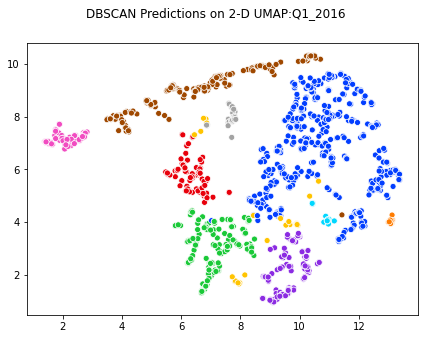

Q2_2016


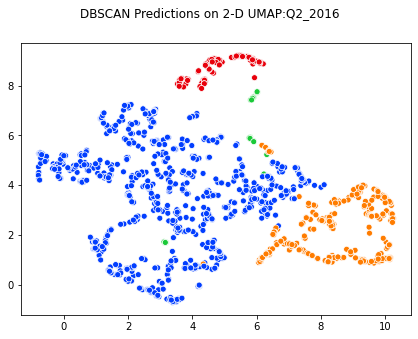

Q3_2016


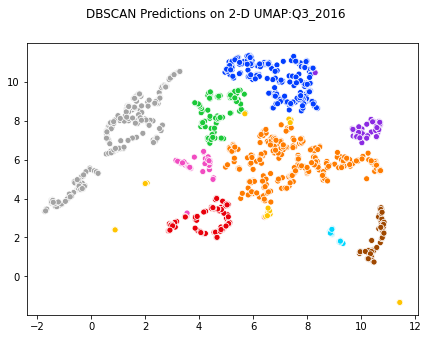

Q4_2016


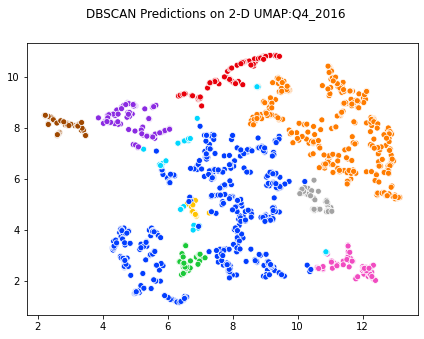

Q1_2017


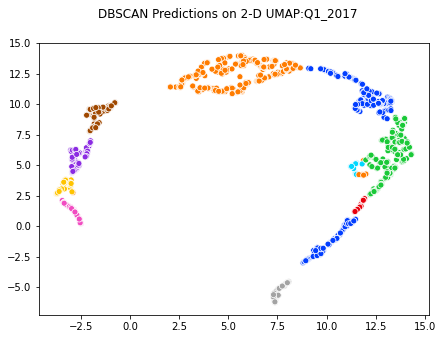

Q2_2017


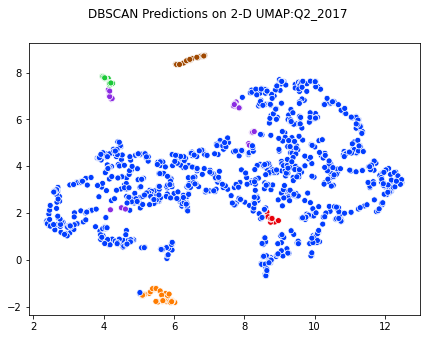

Q3_2017


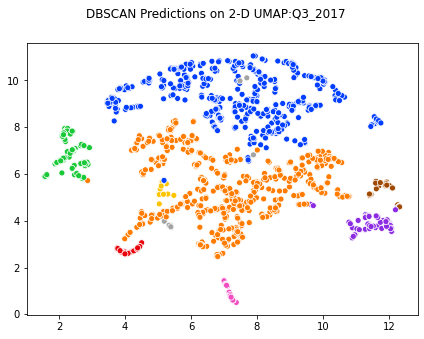

Q4_2017


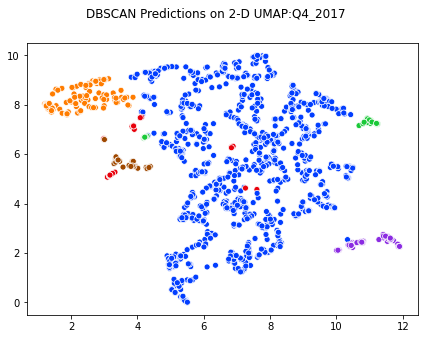

Q1_2018


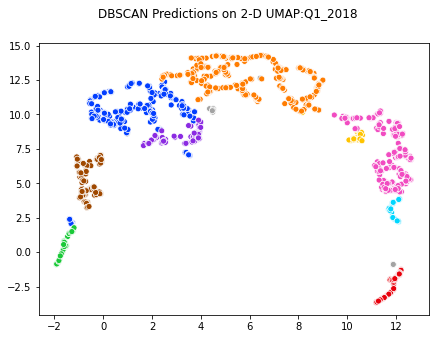

Q2_2018


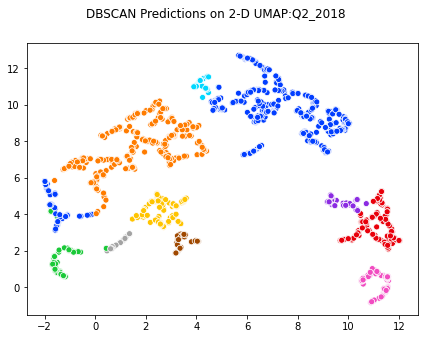

Q3_2018


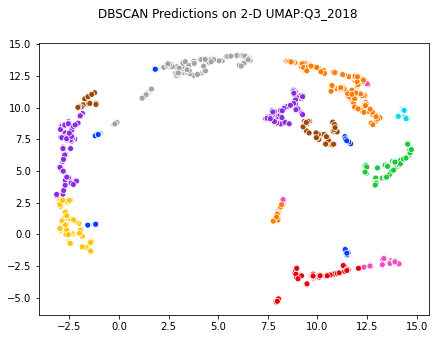

Q4_2018


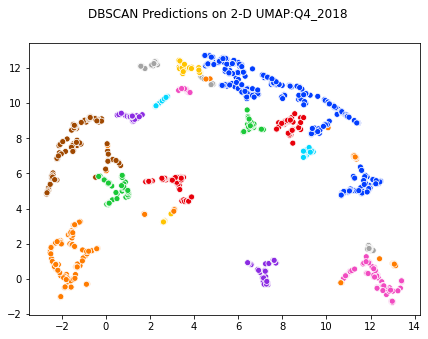

In [7]:
quarterly_db_labels_df = quarter_umap_db_label_comparison(good_quarters,main_df)

The rest of the project continues with Kmeans because it is more durable to identify meaningful clusters across quarters without having to adjust sensitive parameters.

Q1_2016


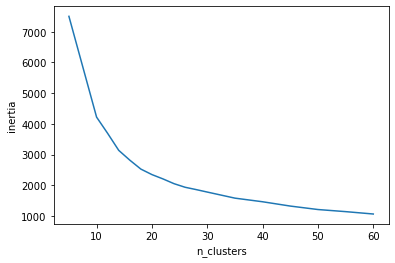

Q2_2016


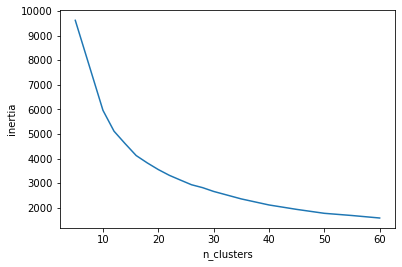

Q3_2016


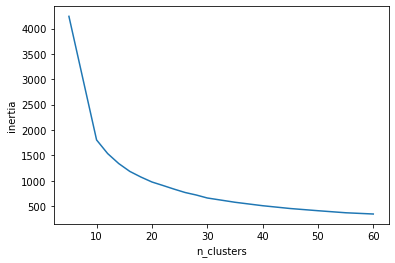

Q4_2016


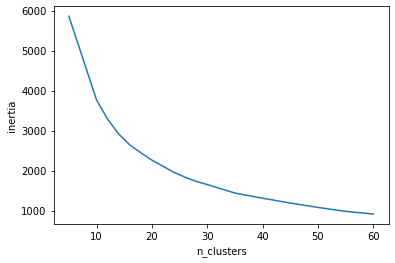

Q1_2017


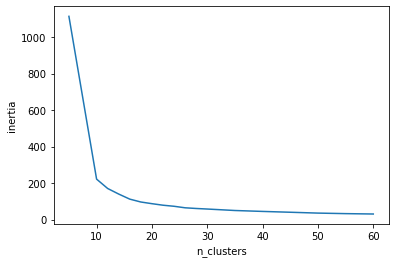

Q2_2017


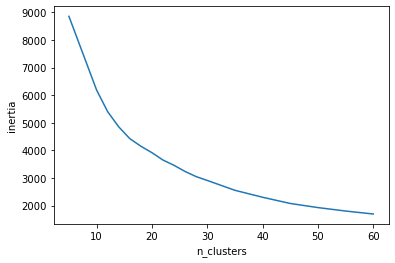

Q3_2017


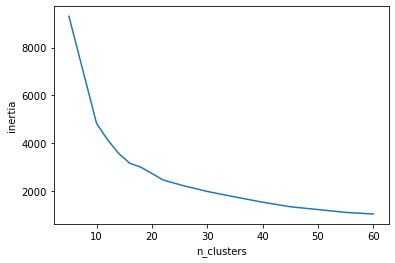

Q4_2017


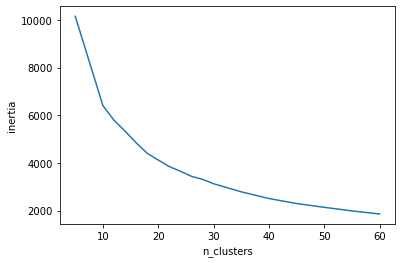

Q1_2018


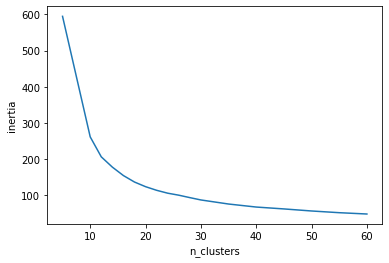

Q2_2018


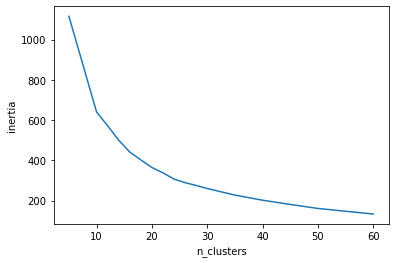

Q3_2018


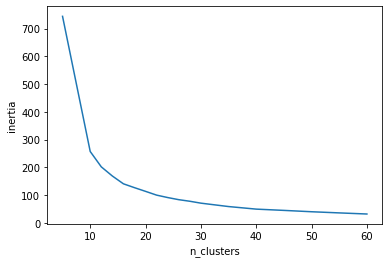

Q4_2018


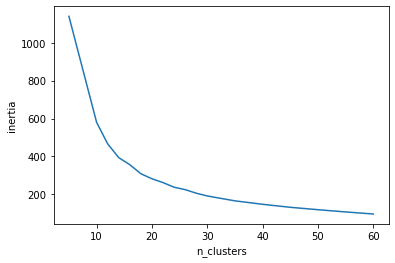

In [8]:
quarterly_labels_df=quarter_label_comparison(good_quarters,main_df)

These are Companies that were not labeled because they did not have data in any of those quarters.

In [9]:
lost_tickers = np.setdiff1d(main_df['Ticker'].unique(),quarterly_labels_df.index)
company_df['Company Name'][company_df['Ticker'].isin(lost_tickers)].values

array(['JOY GLOBAL INC', 'SEARS HOMETOWN & OUTLET STORES, INC.',
       'Shire plc', 'BROADCOM CORP', 'PERRIGO CO',
       'Spectrum Brands Holdings, Inc.', 'Avago Technologies',
       'Endo International', 'Mylan N.V.', 'Allergan Inc.',
       'Arris Group Inc', 'International Game Technology', 'Lsi Corp',
       'ROCKY MOUNTAIN CHOCOLATE FACTORY INC',
       'Tower International, Inc.', 'GARDNER DENVER INC', 'STRATASYS INC',
       'Spy Inc.', 'MAXWELL TECHNOLOGIES INC',
       'COCA-COLA REFRESHMENTS USA, INC.', 'KONA GRILL INC',
       'SolarWinds, Inc.', 'ARQULE INC', 'Invesco Ltd.',
       'Crown Holdings Inc', 'SUPERIOR INDUSTRIES INTERNATIONAL INC',
       'SPARK NETWORKS INC', 'Armstrong Flooring, Inc.',
       'BG Staffing, Inc.', 'Macerich', 'Oxford Immunotec Global PLC',
       'LUNA INNOVATIONS INC', 'GERON CORP',
       'SERVICEMASTER GLOBAL HOLDINGS INC', 'IONIS PHARMACEUTICALS INC',
       'BLUCORA, INC.', 'Platform Specialty Products Corp',
       'Aptevo Therapeutics

Noticable Attrition comes from United Airlines, Dell, Papa Johns, NetGear, Macy's, among several others.  Interestingly While Coca-Cola Refreshment is removed, Coca Cola Co remains (Refreshment being a subsidiary)

In [10]:
high_earnings_dic = {}
low_earnings_dic = {}
high_cash_pct = {}
low_cash_pct_dic = {}
group_df_dic = {}
group_basic ={}
value_count_dic = {}
quarter_df_dic = {}
for quarter in quarterly_labels_df.columns:
    print(quarter)
    quarter_df = main_df[main_df['quarter_year']==quarter]
    id_columns=list(quarter_df.select_dtypes('object').columns)
    id_columns.append('Fiscal Year')
    quarter_df=quarter_df.join(other=quarterly_labels_df[quarter],on='Ticker')
    quarter_df.index=quarter_df['Ticker']
    quarter_df=quarter_df.drop(columns=id_columns)
       
    quarter_group_df = quarter_df.groupby(quarter).mean()
    large_clusters = quarter_df[quarter].value_counts().index[quarter_df[quarter].value_counts()>10]
    
    quarter_group_df=quarter_group_df[quarter_group_df.index.isin(large_clusters)]
    
    value_count_dic[quarter]=quarter_df[quarter].value_counts()[quarter_df[quarter].value_counts()>10]
    group_basic[quarter]=quarter_group_df
    quarter_df_dic[quarter]=quarter_df
    
    scaler=StandardScaler()
    temp_array=scaler.fit_transform(quarter_group_df)

    scaled_means_tall=pd.DataFrame(data=temp_array,columns=quarter_group_df.columns).T

    scaled_means_tall["range"] = (
        scaled_means_tall.max(axis=1) - scaled_means_tall.min(axis=1)
    )
    # fmt: on
    scaled_means_tall["sd"] = scaled_means_tall.std(axis=1)

    scaled_means_tall.sort_values("range", ascending=False).style.background_gradient(axis=1)
    
    group=quarter_group_df.index[quarter_group_df['pct_change_cash']==quarter_group_df['pct_change_cash'].max()][0]
    
    stocks = list(quarter_df.index[quarter_df[quarter]==group])
    high_cash_pct[quarter]=stocks

    group=quarter_group_df.index[quarter_group_df['pct_change_cash']==quarter_group_df['pct_change_cash'].min()][0]
    stocks = list(quarter_df.index[quarter_df[quarter]==group])
    low_cash_pct_dic[quarter]=stocks

    group=quarter_group_df.index[quarter_group_df['Retained Earnings per share']==quarter_group_df['Retained Earnings per share'].max()][0]
    stocks = list(quarter_df.index[quarter_df[quarter]==group])
    high_earnings_dic[quarter]=stocks

    group=quarter_group_df.index[quarter_group_df['Retained Earnings per share']==quarter_group_df['Retained Earnings per share'].min()][0]
    stocks = list(quarter_df.index[quarter_df[quarter]==group])
    low_earnings_dic[quarter]=stocks
    
    group_df_dic[quarter]=scaled_means_tall
    
    

Q1_2016
Q2_2016
Q3_2016
Q4_2016
Q1_2017
Q2_2017
Q3_2017
Q4_2017
Q1_2018
Q2_2018
Q3_2018
Q4_2018


In [11]:
quarter_graph_df = pd.DataFrame({'quarter1':quarterly_labels_df.columns,'quarter2':quarterly_labels_df.columns})
quarter_graph_df['quarter1']=quarter_graph_df['quarter1'].shift()
quarter_graph_df=quarter_graph_df.dropna()

year_on_graph_df=pd.DataFrame({'quarter1':quarterly_labels_df.columns,'quarter2':quarterly_labels_df.columns})
year_on_graph_df['quarter1']=year_on_graph_df['quarter1'].shift(4)
year_on_graph_df=year_on_graph_df.dropna()

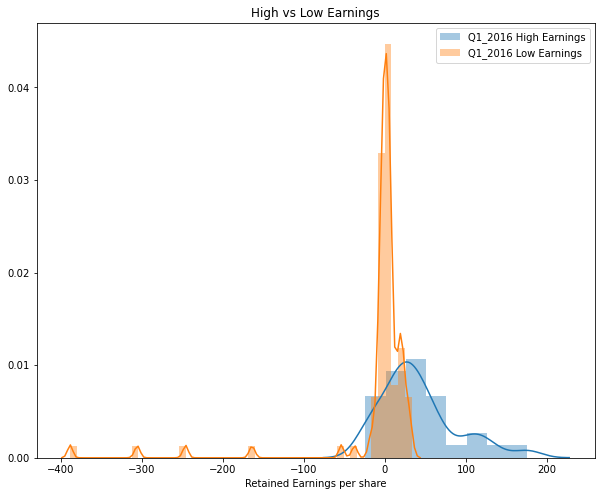

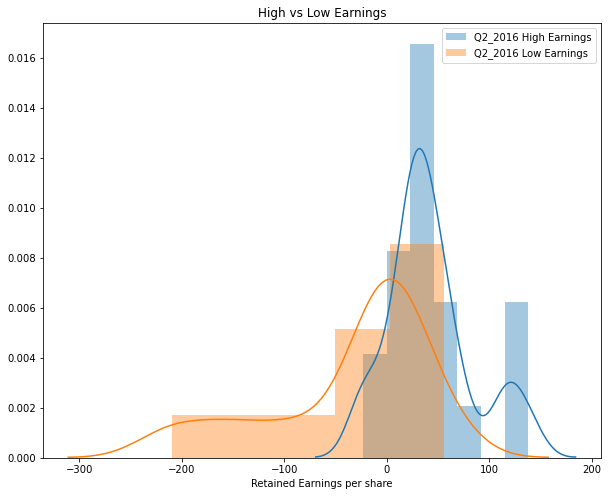

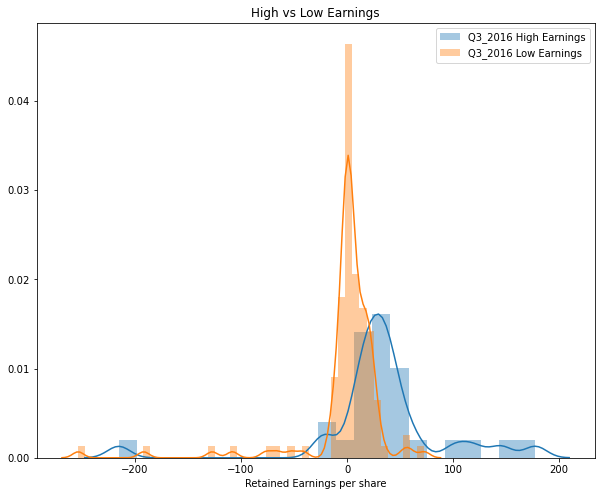

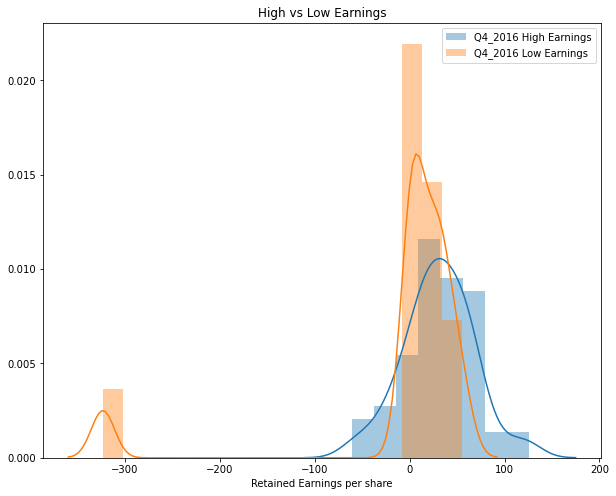

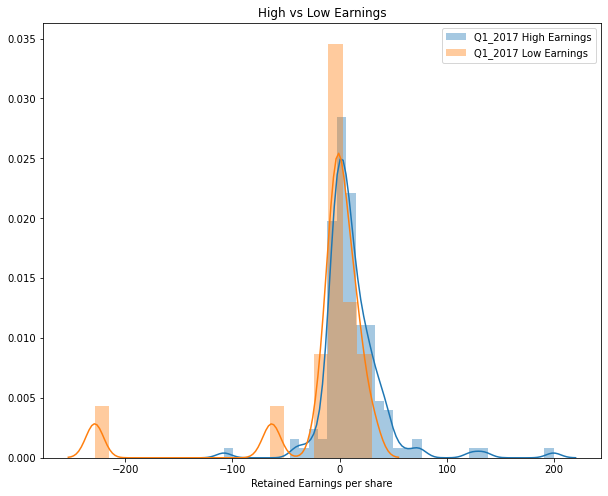

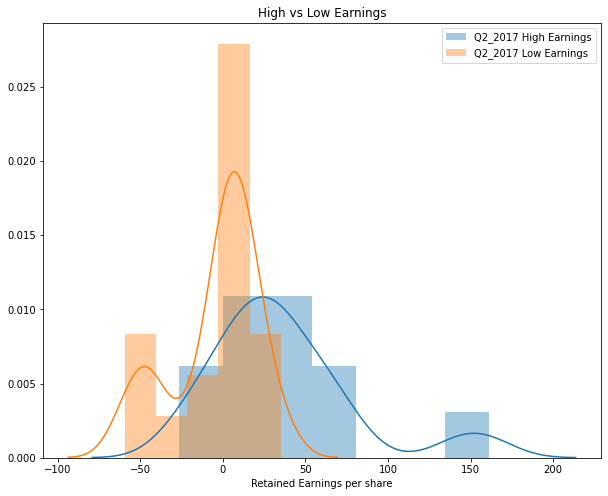

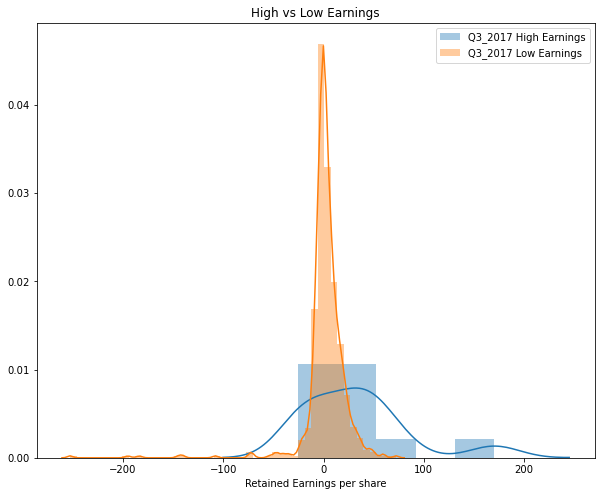

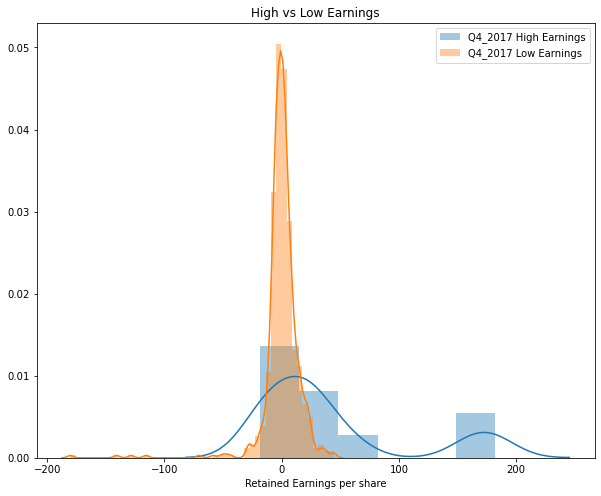

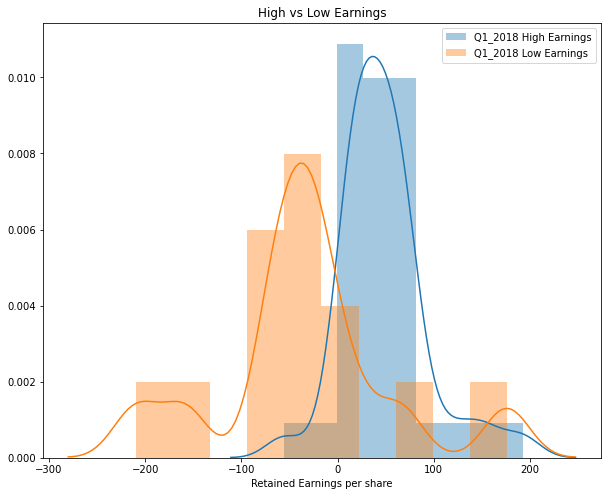

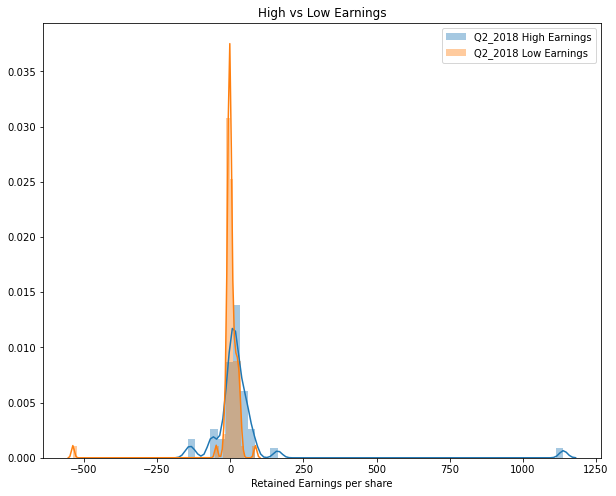

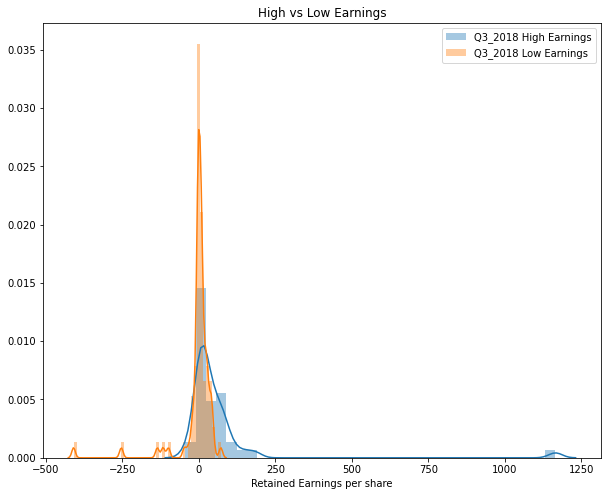

In [12]:
#high earnings vs low earnings
graph_locations =(location + r"\charts")
for x in quarter_graph_df.index:
    q1=quarter_graph_df.loc[x][0]
    q2=quarter_graph_df.loc[x][0]
    
    fig =plt.figure(figsize=(10,8))
    q1_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(high_earnings_dic[q1]))]
    q2_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(low_earnings_dic[q2]))]
    
    sns.distplot(a=q1_data,label=q1+' High Earnings')
    sns.distplot(q2_data,label=q2+' Low Earnings')
    title='High vs Low Earnings'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\earnings_q\\'+q1+q2+title)

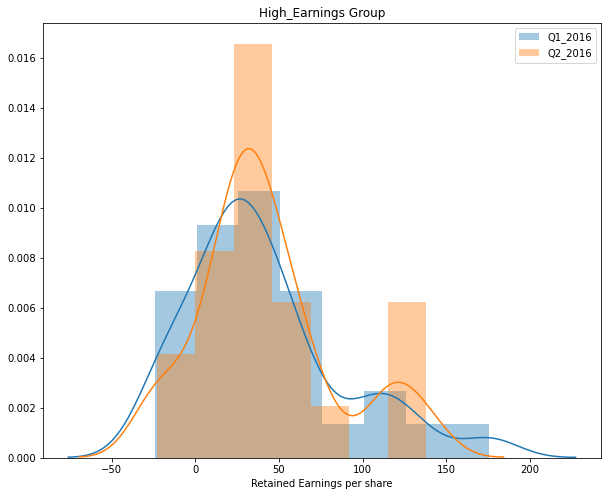

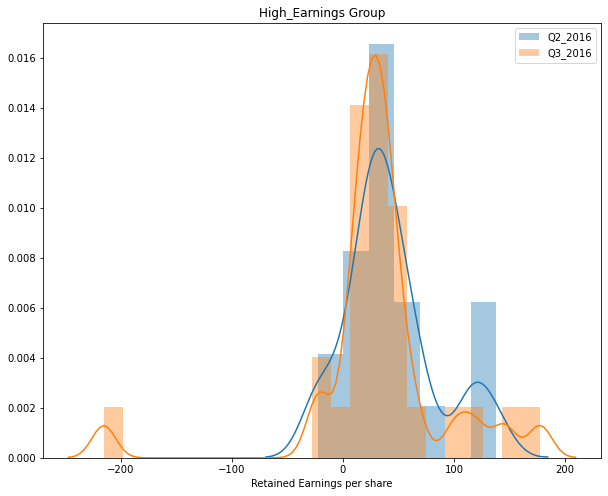

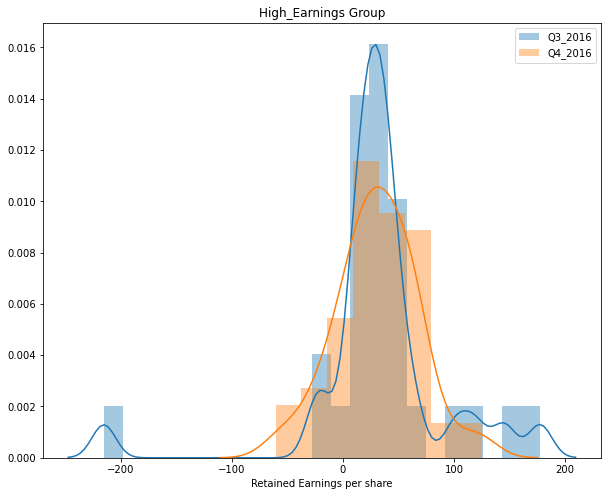

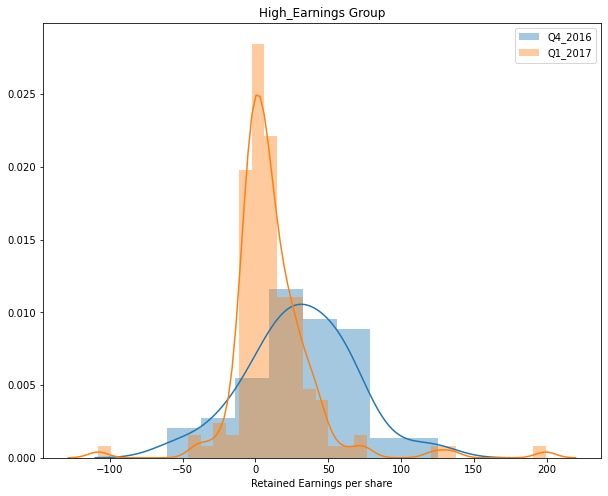

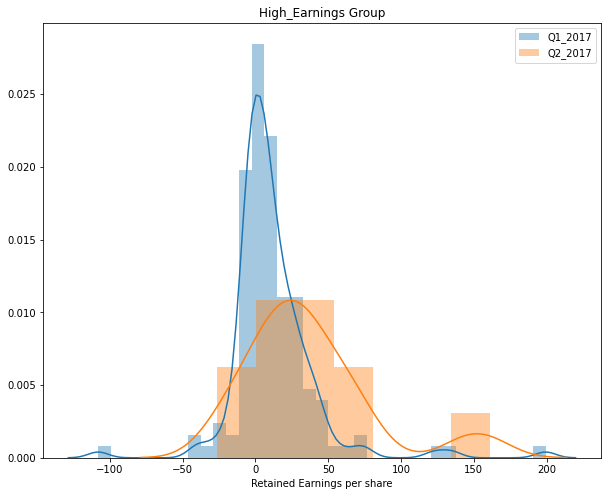

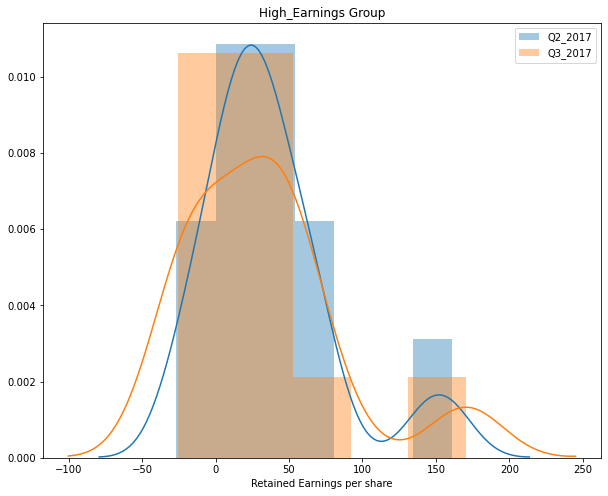

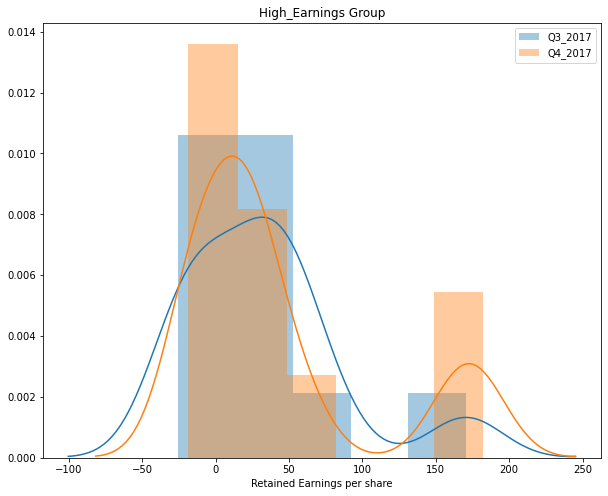

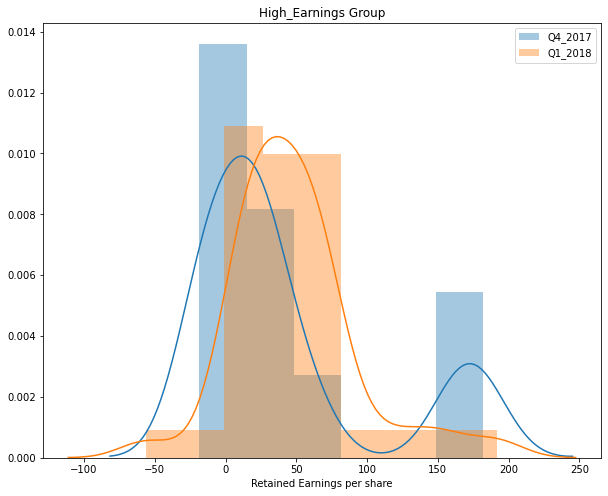

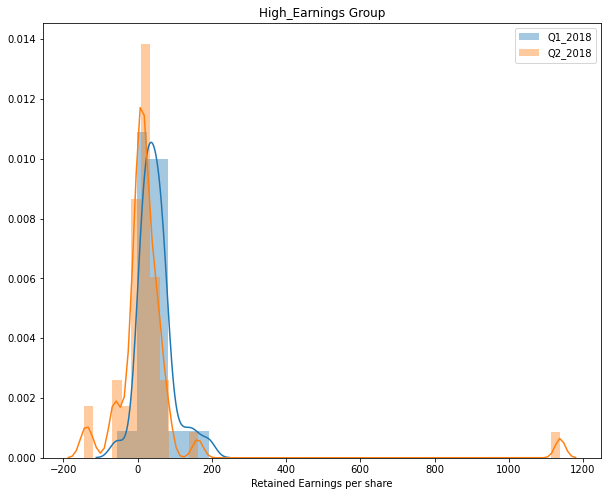

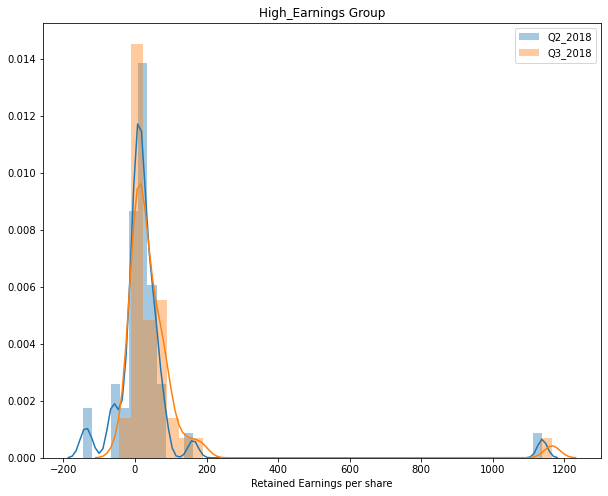

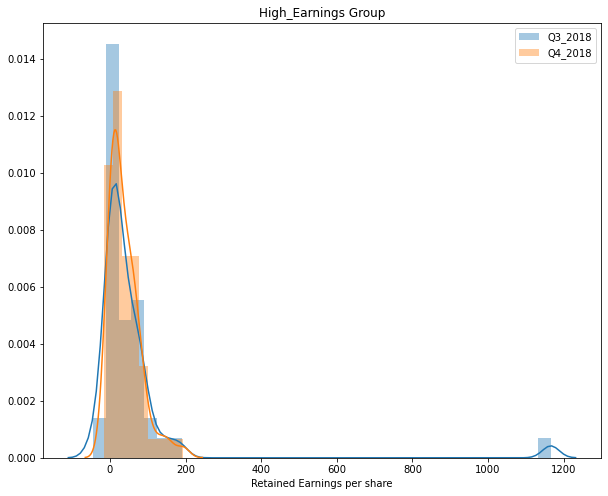

In [13]:
#high earnings across adjacent quarters
for x in quarter_graph_df.index:
    q1=quarter_graph_df.loc[x][0]
    q2=quarter_graph_df.loc[x][1]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(high_earnings_dic[q1]))]
    q2_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(high_earnings_dic[q2]))]
    
    sns.distplot(a=q1_data,label=q1)
    sns.distplot(q2_data,label=q2)
    title='High_Earnings Group'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\high_earnings\\'+q1+q2+title)

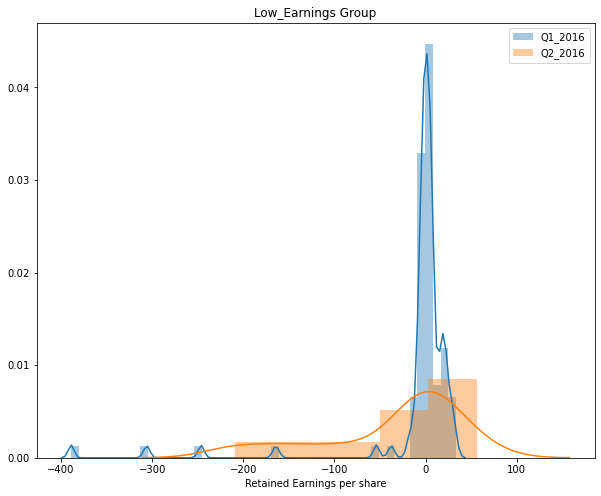

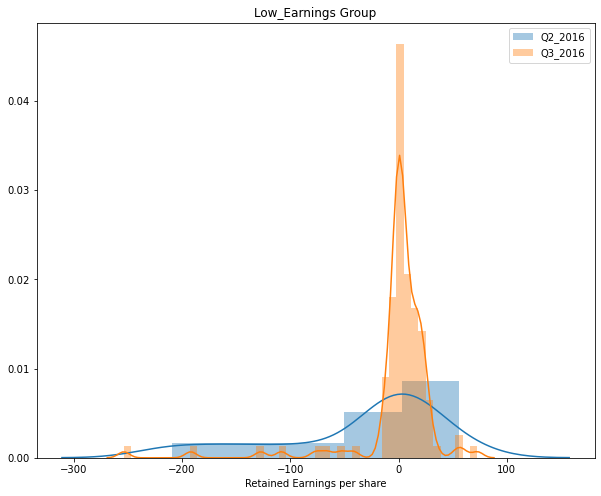

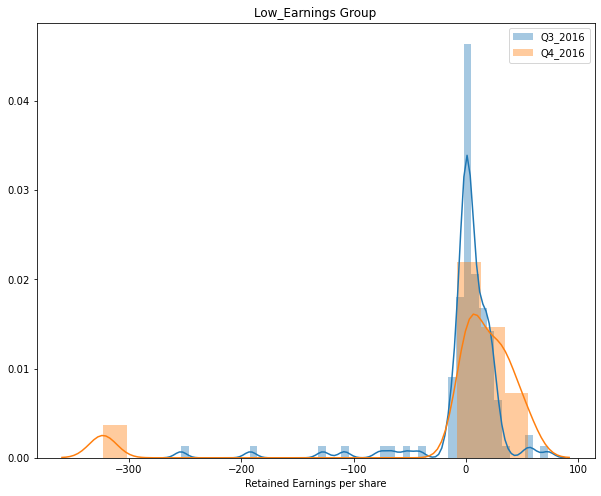

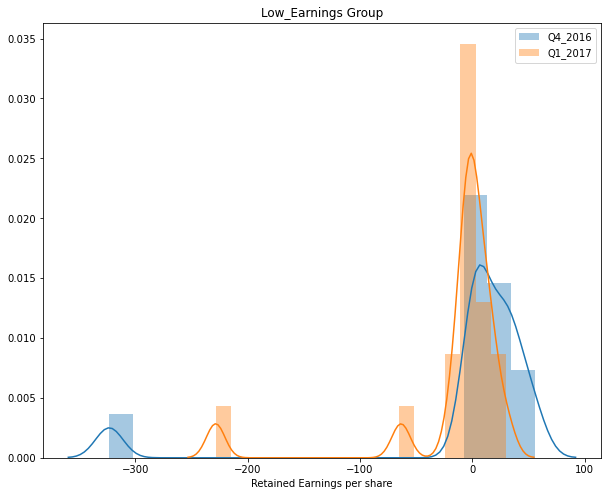

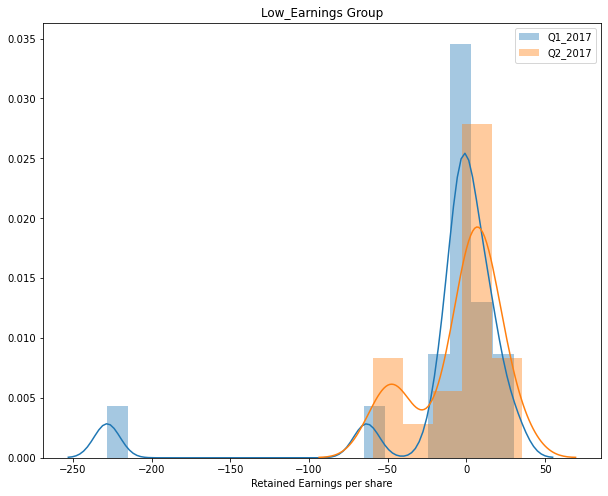

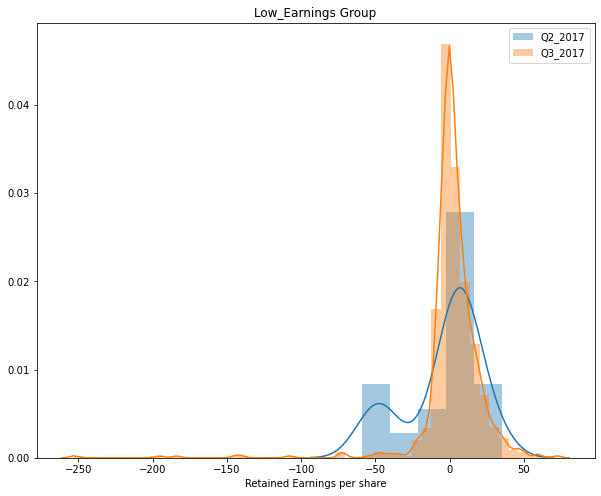

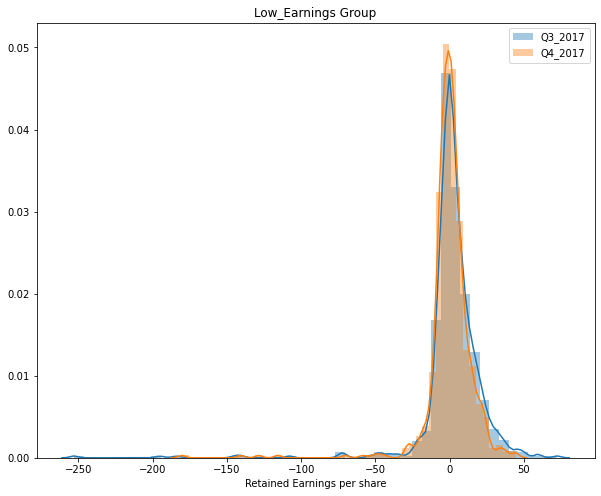

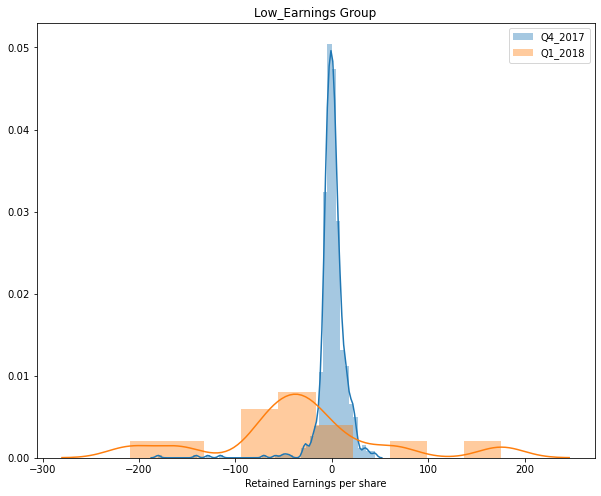

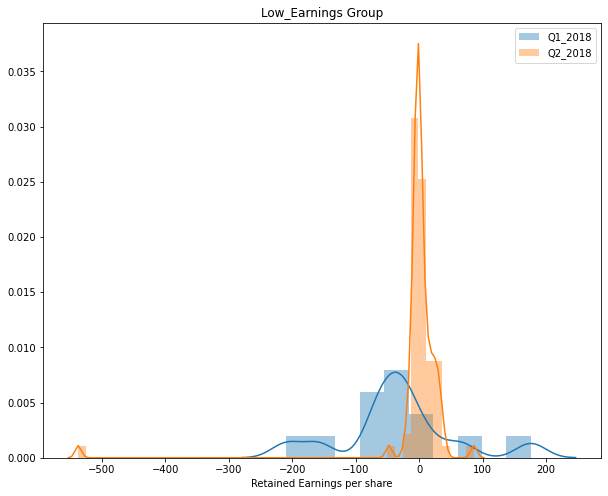

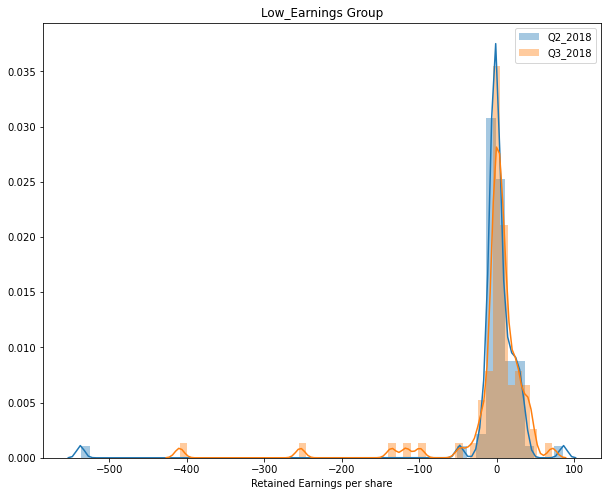

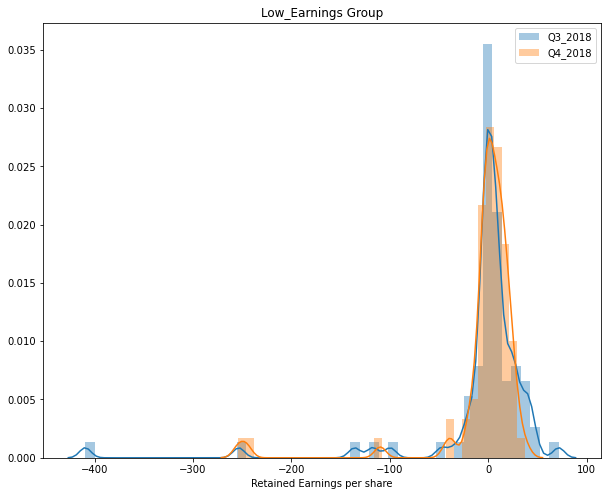

In [14]:
# low earnings across adjacent quarters
for x in quarter_graph_df.index:
    q1=quarter_graph_df.loc[x][0]
    q2=quarter_graph_df.loc[x][1]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(low_earnings_dic[q1]))]
    q2_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(low_earnings_dic[q2]))]
    
    sns.distplot(a=q1_data,label=q1)
    sns.distplot(q2_data,label=q2)
    title='Low_Earnings Group'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\low_earnings\\'+q1+q2+title)

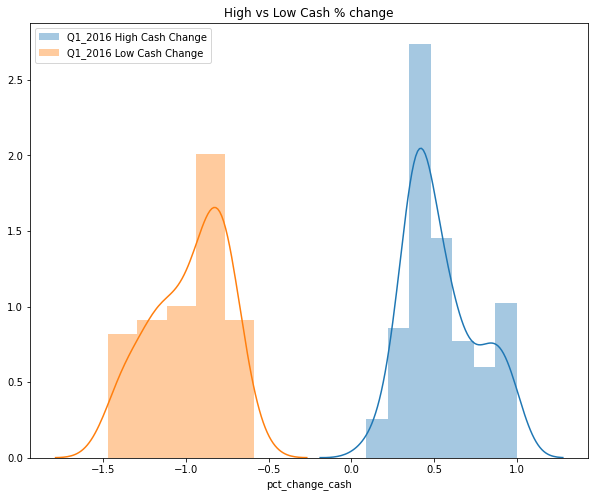

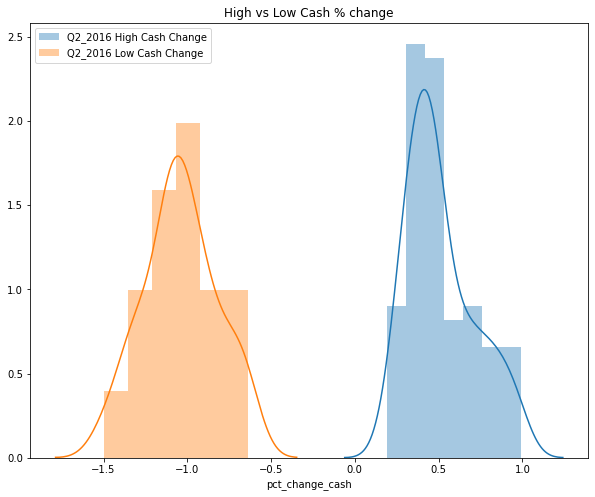

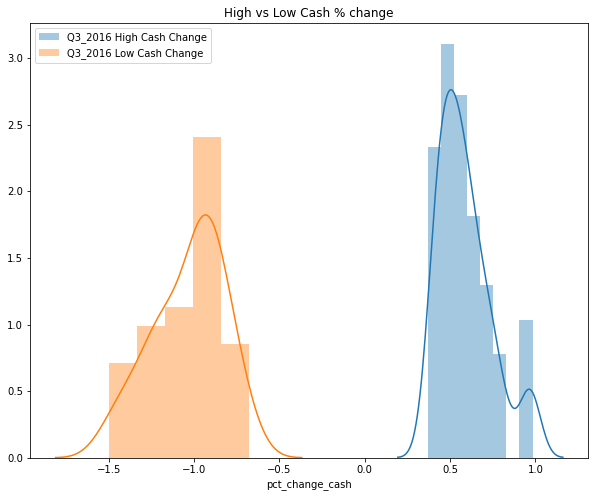

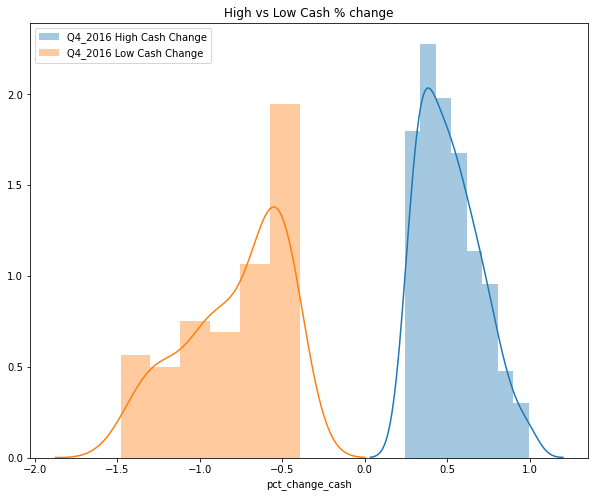

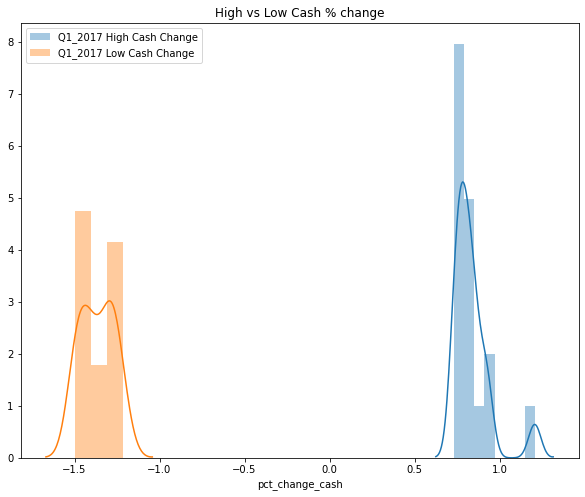

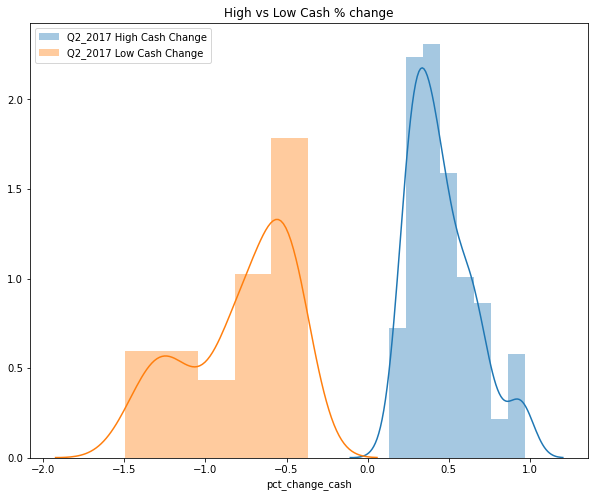

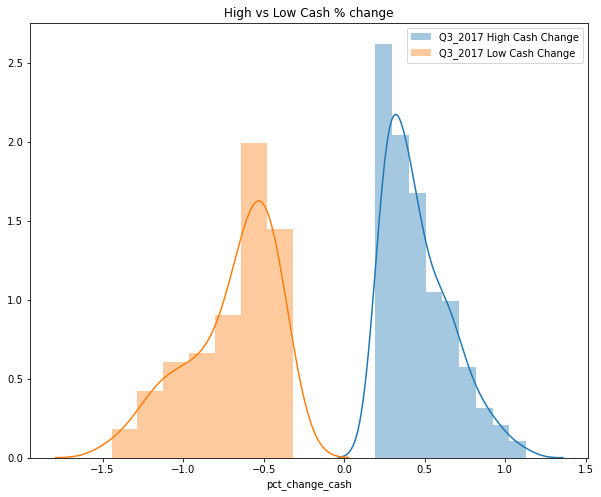

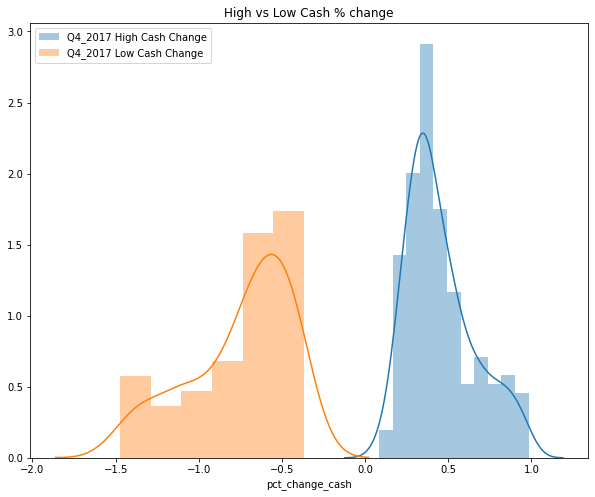

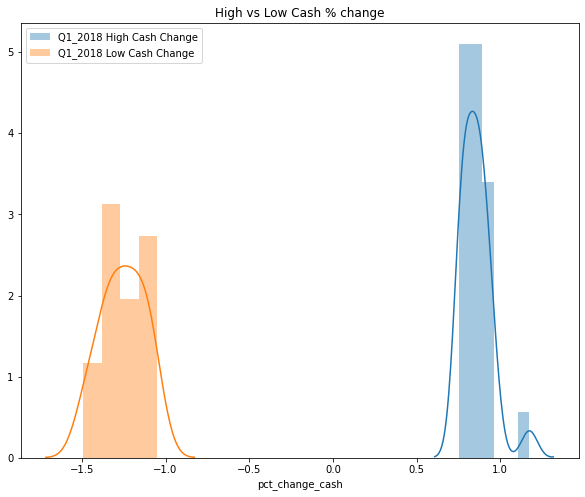

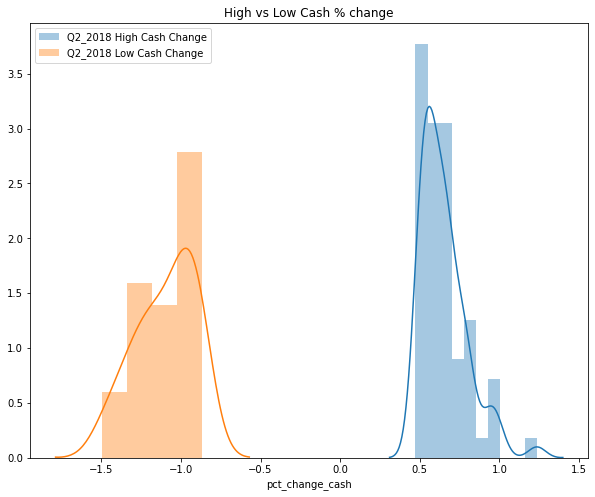

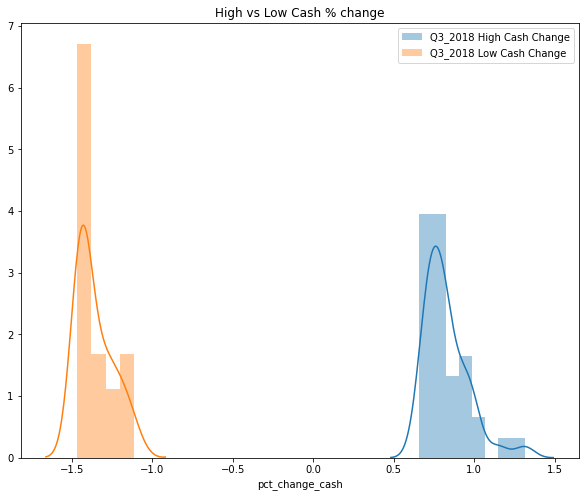

In [15]:
#high vs low cash % change
for x in quarter_graph_df.index:
    q1=quarter_graph_df.loc[x][0]
    q2=quarter_graph_df.loc[x][0]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['pct_change_cash'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(high_cash_pct[q1]))]
    q2_data=main_df['pct_change_cash'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(low_cash_pct_dic[q2]))]
    
    sns.distplot(a=q1_data,label=q1 + ' High Cash Change')
    sns.distplot(q2_data,label=q2 +' Low Cash Change')
    title='High vs Low Cash % change'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\cash_q\\'+q1+q2+title)

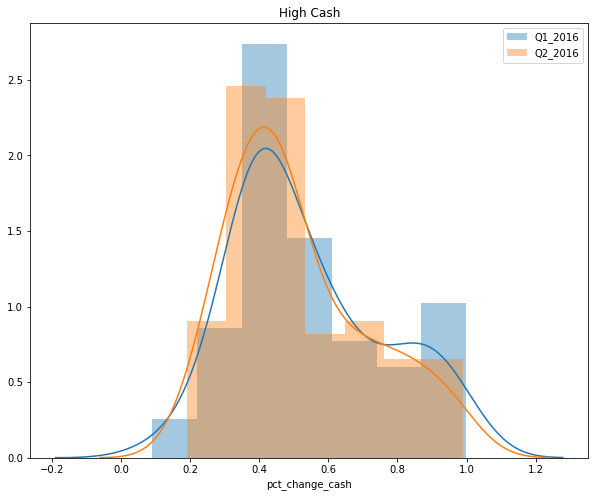

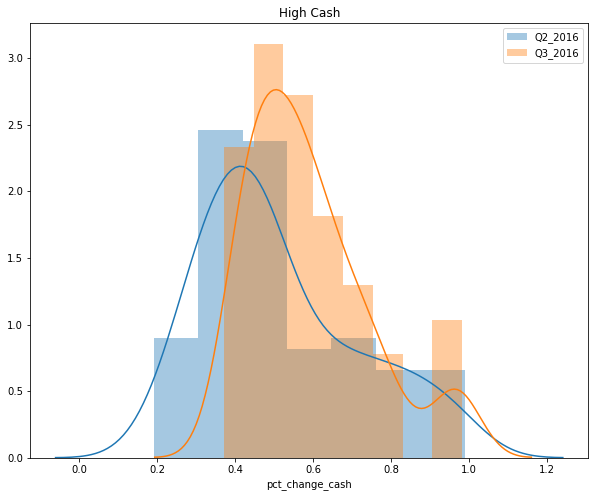

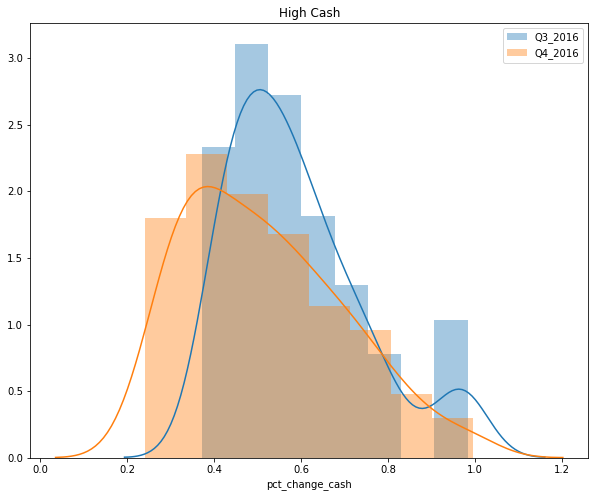

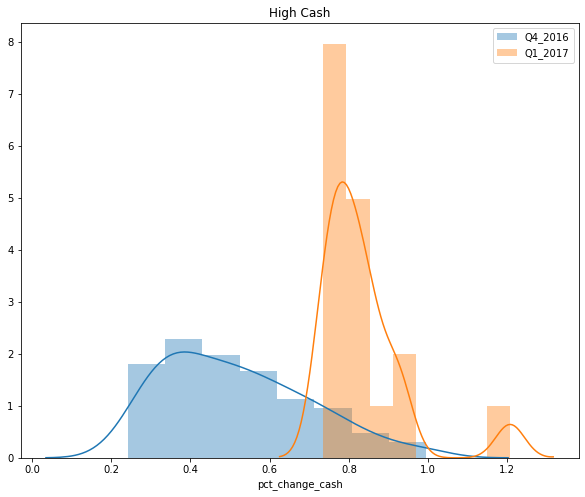

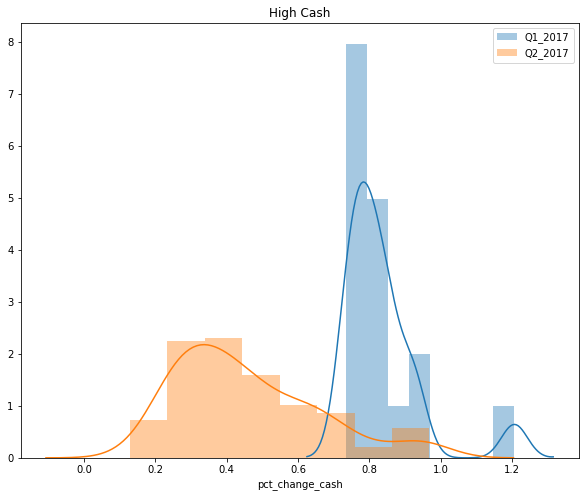

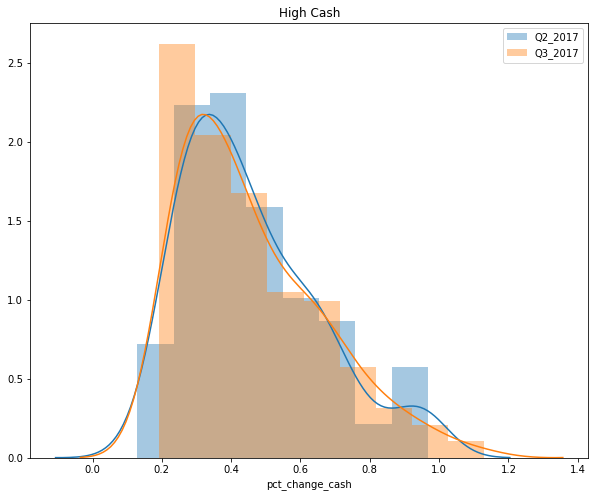

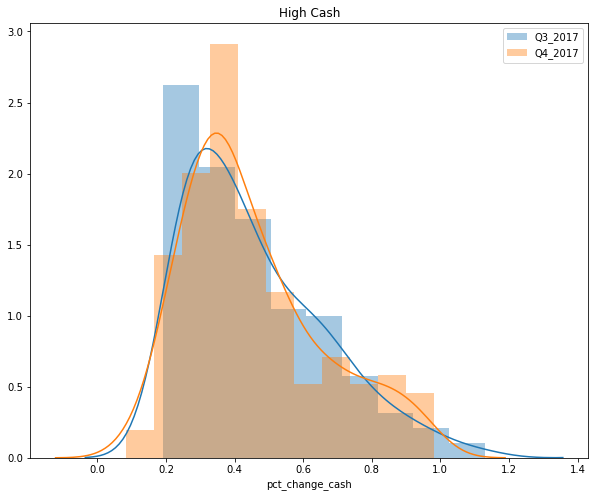

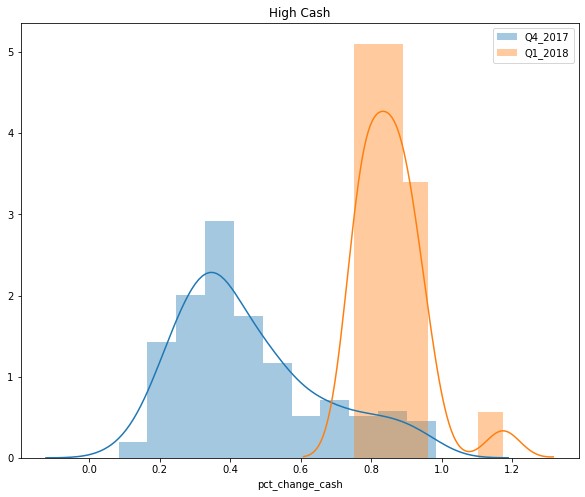

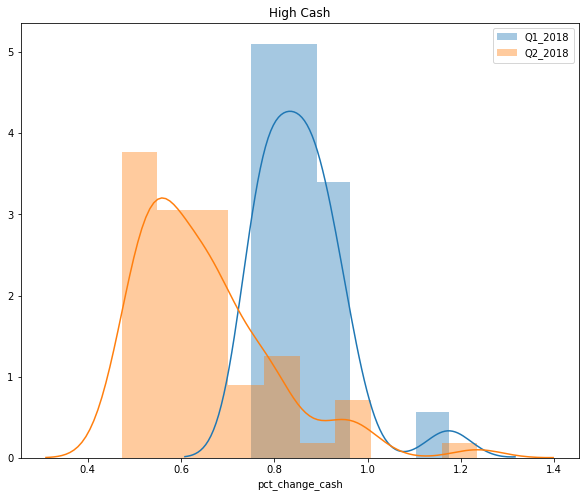

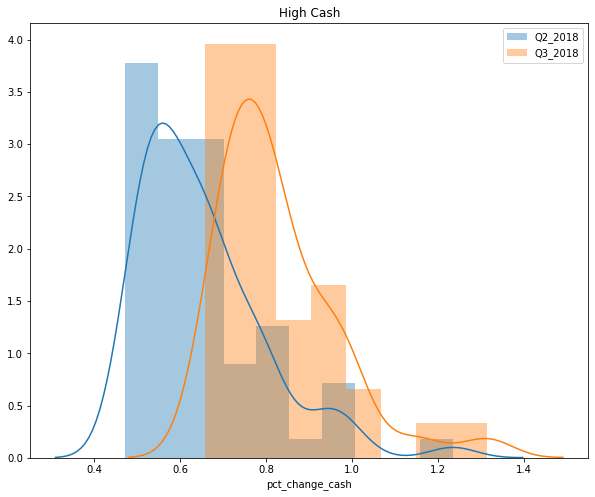

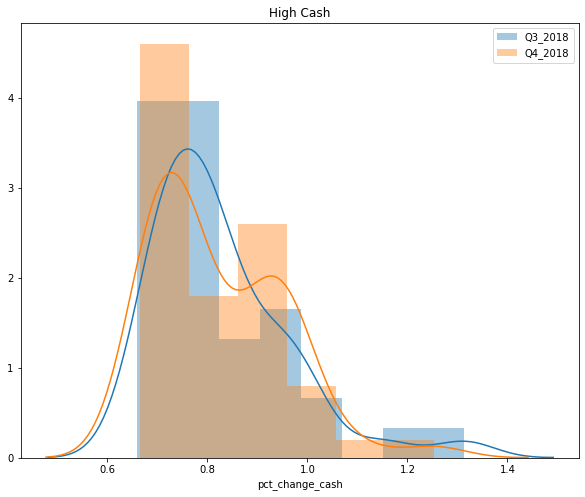

In [16]:
#high cash across adjacent quarters
for x in quarter_graph_df.index:
    q1=quarter_graph_df.loc[x][0]
    q2=quarter_graph_df.loc[x][1]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['pct_change_cash'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(high_cash_pct[q1]))]
    q2_data=main_df['pct_change_cash'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(high_cash_pct[q2]))]
    
    sns.distplot(a=q1_data,label=q1)
    sns.distplot(q2_data,label=q2)
    title='High Cash'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\high_cash\\'+q1+q2+title)

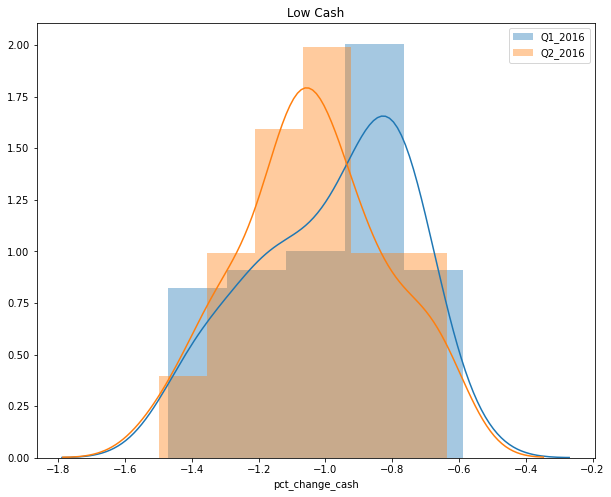

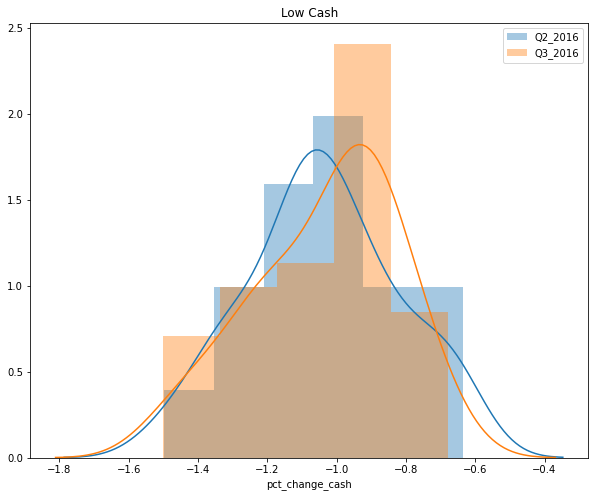

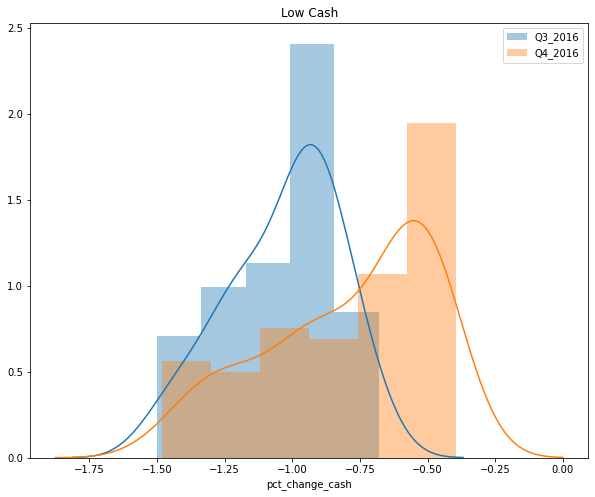

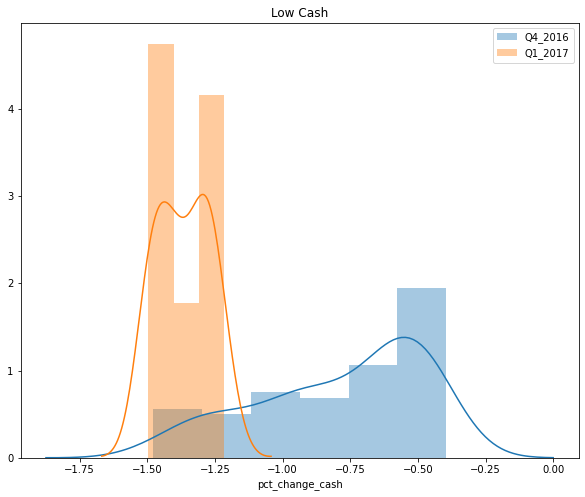

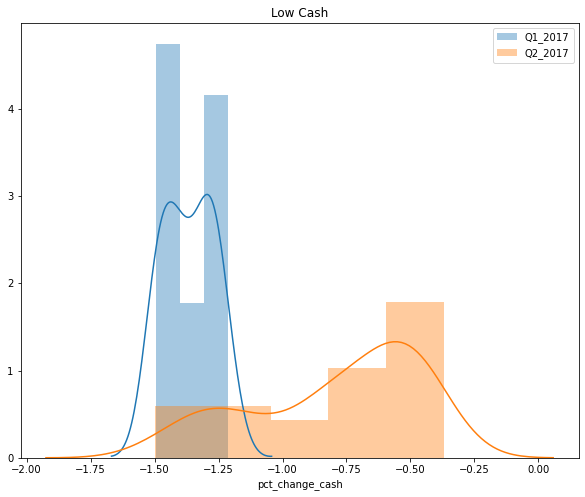

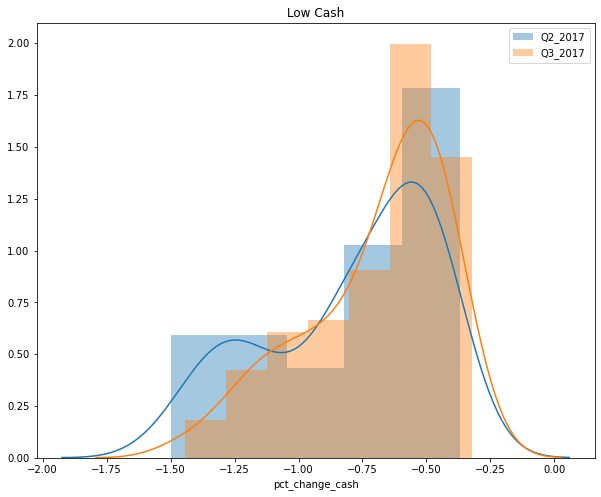

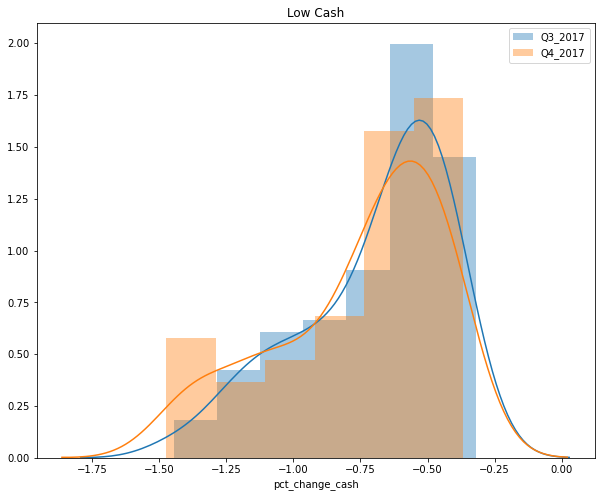

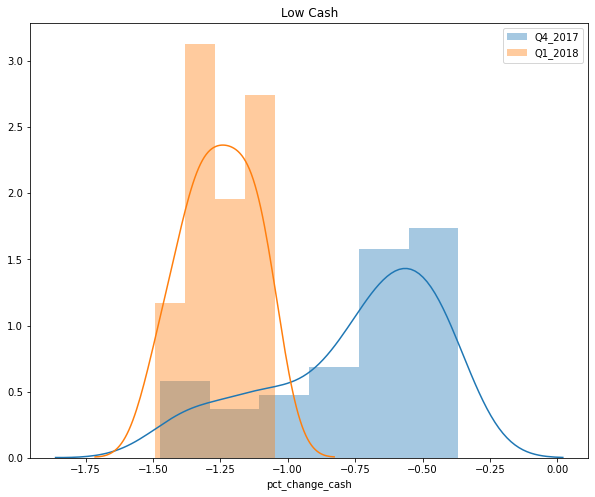

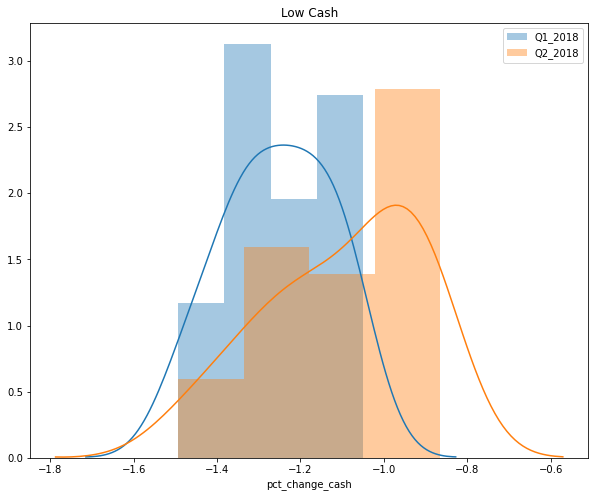

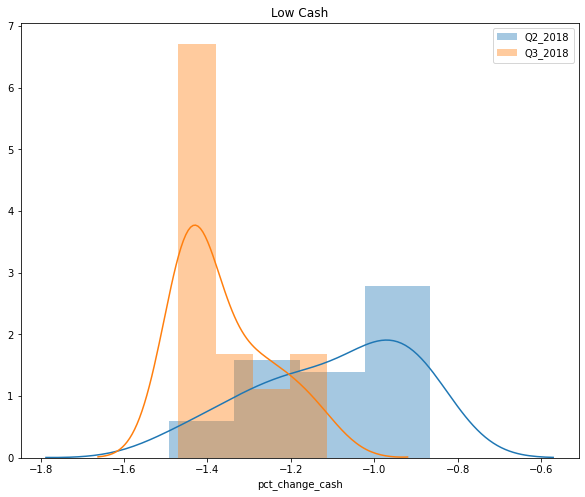

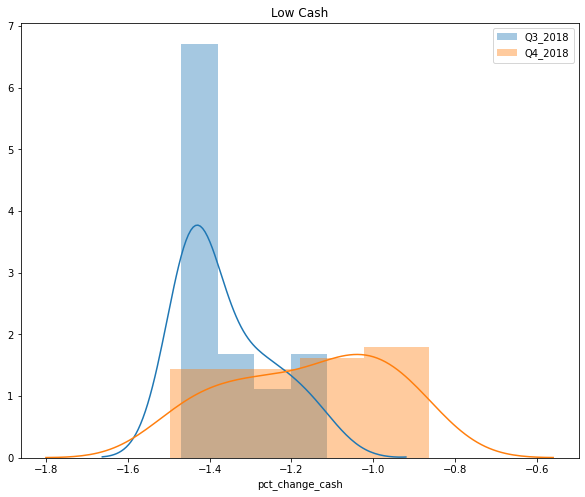

In [17]:
#low cash across adjacent quarters
for x in quarter_graph_df.index:
    q1=quarter_graph_df.loc[x][0]
    q2=quarter_graph_df.loc[x][1]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['pct_change_cash'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(low_cash_pct_dic[q1]))]
    q2_data=main_df['pct_change_cash'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(low_cash_pct_dic[q2]))]
    
    sns.distplot(a=q1_data,label=q1)
    sns.distplot(q2_data,label=q2)
    title='Low Cash'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\low_cash\\'+q1+q2+title)

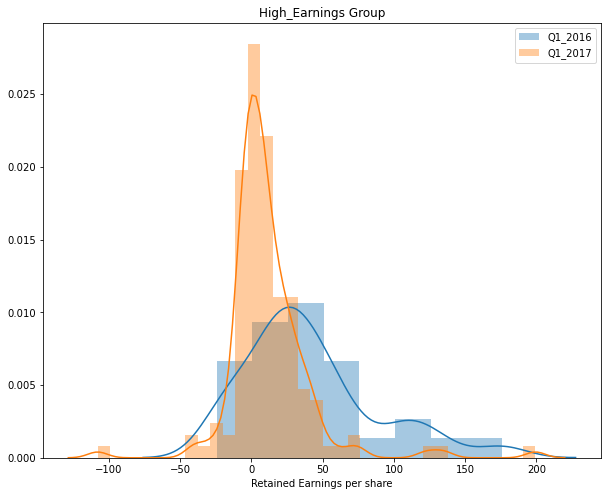

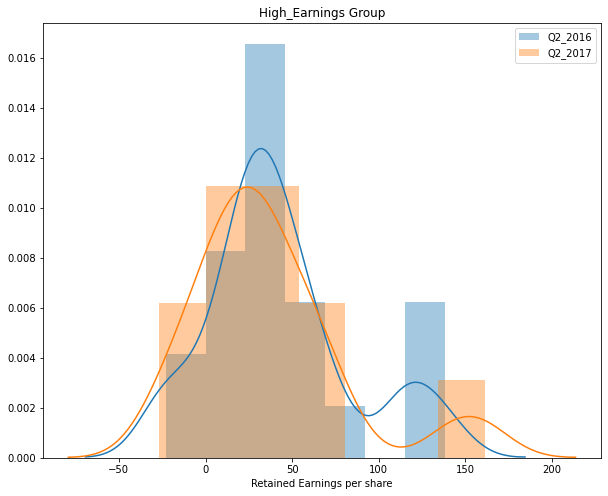

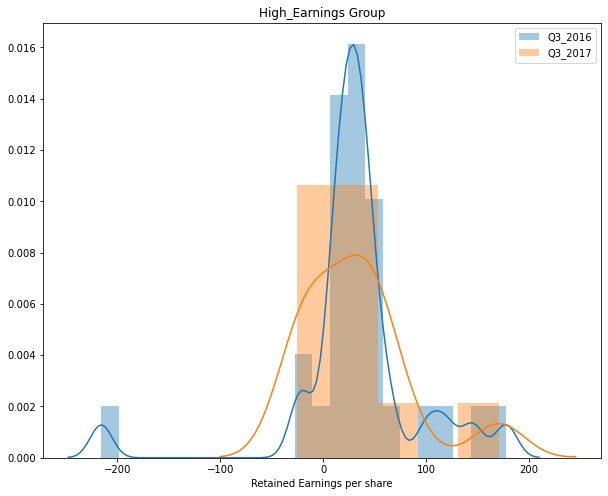

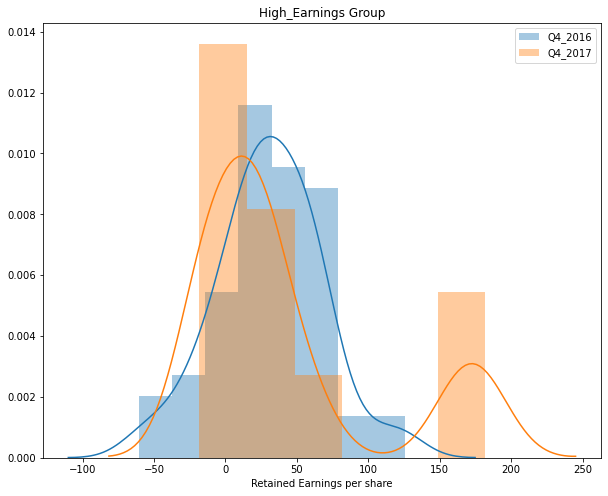

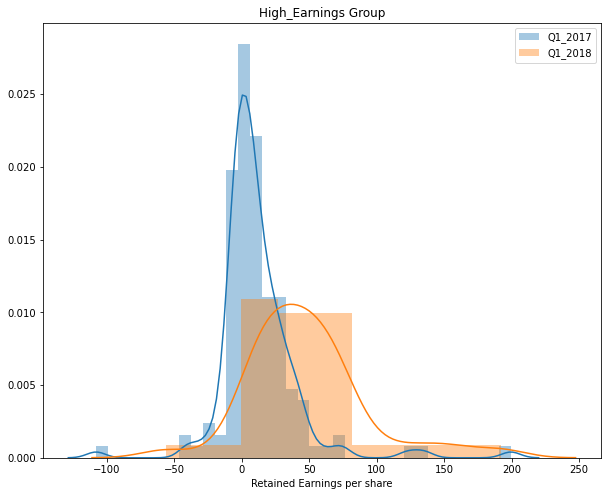

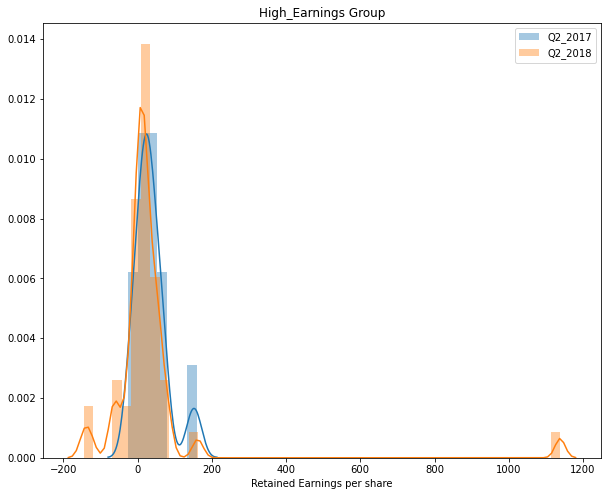

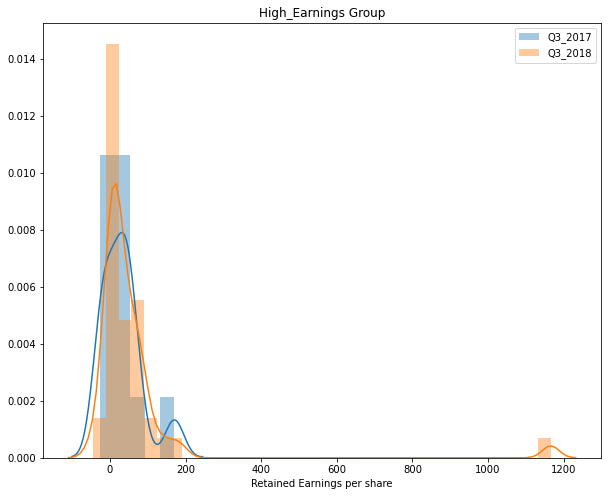

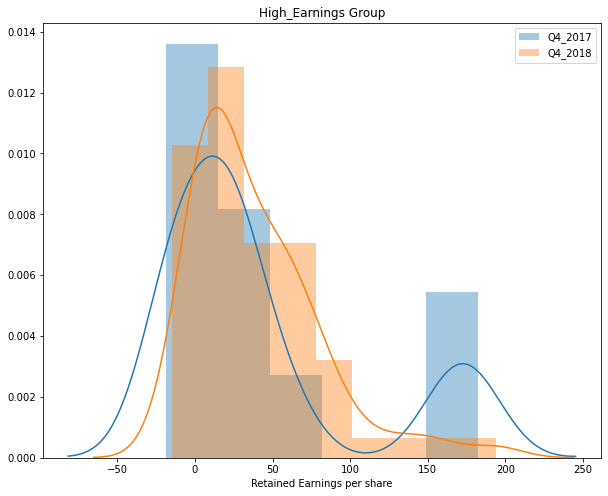

In [18]:
#high earnings year on year
for x in year_on_graph_df.index:
    q1=year_on_graph_df.loc[x][0]
    q2=year_on_graph_df.loc[x][1]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(high_earnings_dic[q1]))]
    q2_data=main_df['Retained Earnings per share'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(high_earnings_dic[q2]))]
    
    sns.distplot(a=q1_data,label=q1)
    sns.distplot(q2_data,label=q2)
    title='High_Earnings Group'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\earnings_y\\'+q1+q2+title)

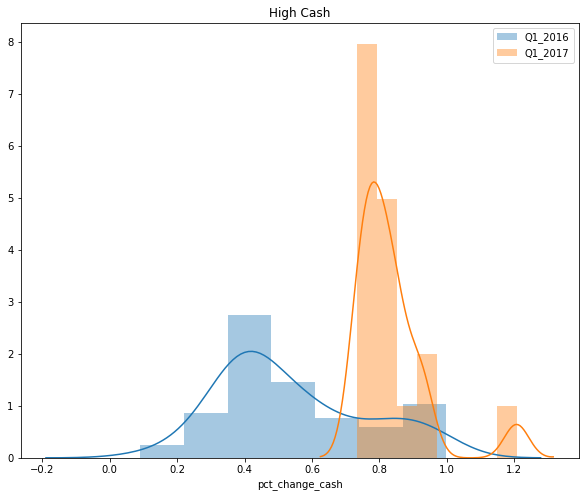

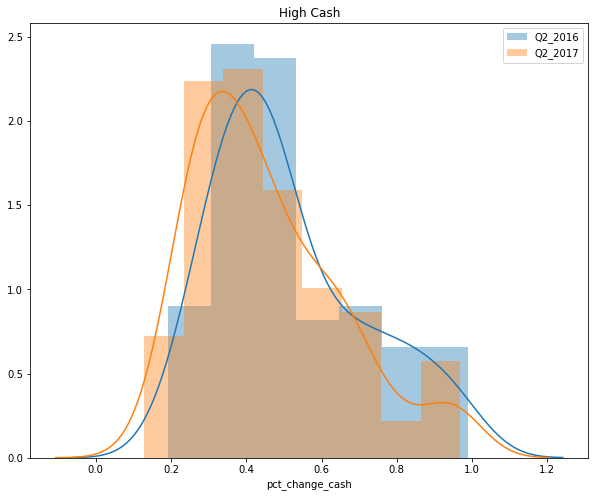

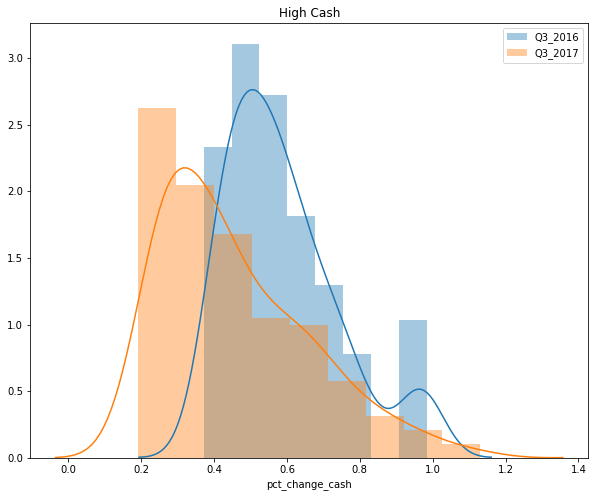

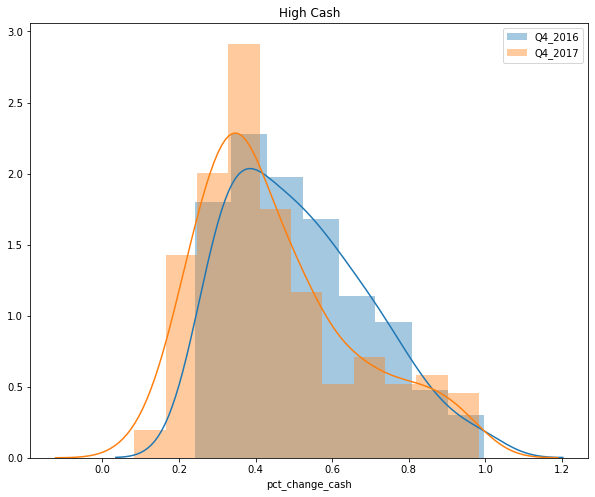

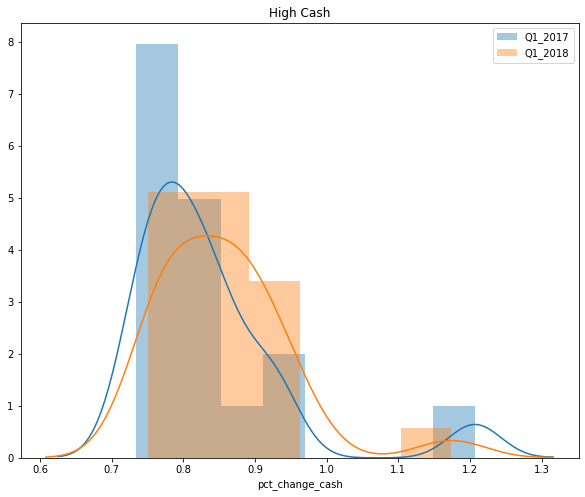

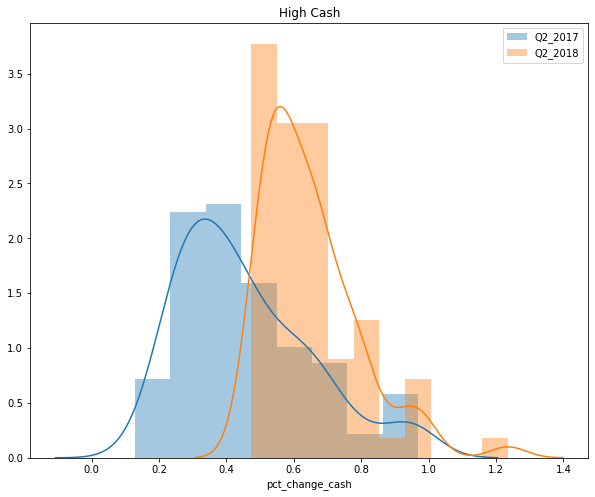

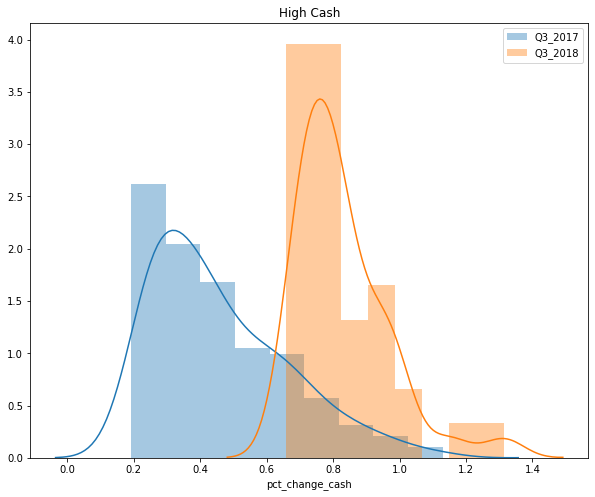

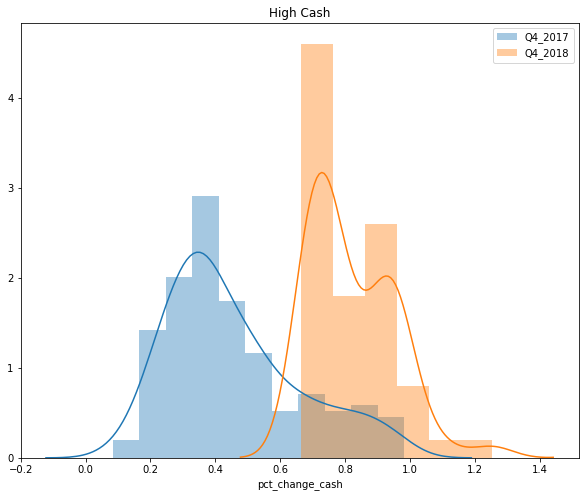

In [19]:
#high cash year on year
for x in year_on_graph_df.index:
    q1=year_on_graph_df.loc[x][0]
    q2=year_on_graph_df.loc[x][1]
    
    fig=plt.figure(figsize=(10,8))
    q1_data=main_df['pct_change_cash'][(main_df['quarter_year']==q1) & (main_df['Ticker'].isin(high_cash_pct[q1]))]
    q2_data=main_df['pct_change_cash'][(main_df['quarter_year']==q2) & (main_df['Ticker'].isin(high_cash_pct[q2]))]
    
    sns.distplot(a=q1_data,label=q1)
    sns.distplot(q2_data,label=q2)
    title='High Cash'
    plt.title(title)
    plt.legend()
    plt.show()
    fig.savefig(graph_locations+'\\cash_y\\'+q1+q2+title)

Takeaways: Earnings are not particularly distinguishable.  The mean may be different but the distribution overlaps.  % change cash is noticeable across quarters, but is less prominent on a year by year basis.  The difference nonetheless remains substantive, but there is a seasonal aspect to it.  Within quarters though, the dividing line between high and low cash % is prominent.

Q1 2018 stocks in high earning groups.  Some notable names like Amazon, Black Rock and Ulta, but they don't all have particularly good earnings as seen in the graph

In [20]:
main_df['Company Name'][main_df['Ticker'].isin(high_earnings_dic['Q1_2018'])].unique()

array(['Accenture plc', 'ALLIANCE DATA SYSTEMS CORP',
       'Allegiant Travel CO', 'Amc Networks Inc',
       'AFFILIATED MANAGERS GROUP, INC.', 'AMAZON COM INC', 'Aon plc',
       'BlackRock, Inc.', 'CATERPILLAR INC', 'Celanese Corp',
       'Charter Communications', 'CUMMINS INC', 'COHERENT INC',
       'Cooper-Standard Holdings Inc.', 'CAVCO INDUSTRIES INC.',
       "DILLARD'S, INC.", 'FEDEX CORP', 'GRAINGER W W INC',
       'HUNTINGTON INGALLS INDUSTRIES, INC.', 'Helmerich & Payne, Inc.',
       'LEAR CORP', 'LAM RESEARCH CORP', 'MCCORMICK & CO INC',
       'NORTHROP GRUMMAN CORP /DE/', 'O REILLY AUTOMOTIVE INC',
       'PVH CORP. /DE/', 'Reliance Steel & Aluminum Co',
       'RSP Permian Inc', 'RAYTHEON CO/', 'SANDERSON FARMS INC',
       'Sherwin-Williams', 'LendingTree, Inc.', 'T. Rowe Price Group',
       'Trinseo S.A.', 'TYSON FOODS INC', 'Amerco',
       'Ulta Salon, Cosmetics & Fragrance, Inc.',
       'UNITED RENTALS INC /DE', 'WABCO Holdings Inc.',
       'Willis Towers W

Q1 2018 stocks in low earning groups.  Some notable names like Pier 1 Imports, Valeant and Tesla

In [21]:
main_df['Company Name'][main_df['Ticker'].isin(low_earnings_dic['Q1_2018'])].unique()

array(['CIENA CORP', 'DOCUSIGN INC', 'Denali Holding Inc.',
       'INTERCEPT PHARMACEUTICALS INC', 'iHeartMedia, Inc.',
       'NEWLINK GENETICS CORP', 'NOVAVAX INC', 'PIER 1 IMPORTS INC/DE',
       'QUALCOMM INC/DE', 'SIGNET JEWELERS LTD', 'Tesla',
       'Valeant Pharmaceuticals International, Inc.',
       'EXCO RESOURCES INC'], dtype=object)

Q1 2018 stocks in high cash % group.  This includes Cheesecake Factory and Carmax

In [22]:
main_df['Company Name'][main_df['Ticker'].isin(high_cash_pct['Q1_2018'])].unique()

array(['American Homes 4 Rent', 'Bravo Brio Restaurant Group, Inc.',
       'CRAFT BREW ALLIANCE, INC.', 'CHEESECAKE FACTORY INC',
       'CENTRAL GARDEN & PET CO', 'California Resources Corp', 'CSX CORP',
       'CTI BIOPHARMA CORP', 'DOMINION RESOURCES INC /VA/',
       'DYNATRONICS CORP', 'GRAFTECH INTERNATIONAL LTD',
       'Eversource Energy', 'FLOWERS FOODS INC', 'IDACORP INC',
       'Intrepid Potash, Inc.', 'CARMAX INC', 'Level Brands, Inc.',
       'Outlook Therapeutics, Inc.', 'PENTAIR plc',
       'PASSUR Aerospace, Inc.', 'PATTERSON UTI ENERGY INC',
       'S&W Seed Co', 'USA TECHNOLOGIES INC', 'VIRCO MFG CORPORATION',
       'Youngevity International, Inc.'], dtype=object)

Q1 2018 stocks in low cash % group.  This includes John Deere, Six Flags, Scots Miracle-Gro and Molson Coors.

In [23]:
main_df['Company Name'][main_df['Ticker'].isin(low_cash_pct_dic['Q1_2018'])].unique()

array(['ATLAS AIR WORLDWIDE HOLDINGS INC', 'ABBOTT LABORATORIES',
       'Bunge LTD', 'Church & Dwight', 'DEERE & CO',
       'DUN & BRADSTREET CORP/NW', 'CALLAWAY GOLF CO', 'EP Energy Corp',
       'Hawaiian Telcom Holdco, Inc.', 'LIVE VENTURES Inc', 'Mattel Inc.',
       'Mallinckrodt plc', 'MATERION Corp', 'Packaging Corp Of America',
       'SCANSOURCE INC', 'Six Flags Entertainment Corp',
       'SCOTTS MIRACLE-GRO CO', 'MOLSON COORS BREWING CO',
       'TESSCO TECHNOLOGIES INC', 'TARGET CORP',
       'Tabula Rasa HealthCare, Inc.', 'TRANS WORLD ENTERTAINMENT CORP',
       'Xperi Corp'], dtype=object)

Generate additional graphs for presentation:

In [24]:
quarter_list = []
max_list = []
min_list = []
for quarter in group_basic.keys():
    temp_df = group_basic[quarter]
    high = temp_df['Retained Earnings per share'][temp_df['Retained Earnings per share']==temp_df['Retained Earnings per share'].max()].values[0]
    low = temp_df['Retained Earnings per share'][temp_df['Retained Earnings per share']==temp_df['Retained Earnings per share'].min()].values[0]
    quarter_list.append(quarter)
    max_list.append(high)
    min_list.append(low)
    
earnings_min_max_df = pd.DataFrame({'Quarter':quarter_list,'Max Mean Earnings':max_list,'Min Mean Earnings':min_list})
earnings_min_max_df['Difference']=earnings_min_max_df['Max Mean Earnings']-earnings_min_max_df['Min Mean Earnings']

In [25]:
quarter_list = []
max_list = []
min_list = []
for quarter in group_basic.keys():
    temp_df = group_basic[quarter]
    high = temp_df['pct_change_cash'][temp_df['pct_change_cash']==temp_df['pct_change_cash'].max()].values[0]
    low = temp_df['pct_change_cash'][temp_df['pct_change_cash']==temp_df['pct_change_cash'].min()].values[0]
    quarter_list.append(quarter)
    max_list.append(high)
    min_list.append(low)
    
cash_min_max_df = pd.DataFrame({'Quarter':quarter_list,'Max Mean Cash Change':max_list,'Min Mean Cash Change':min_list})
cash_min_max_df['Difference']=cash_min_max_df['Max Mean Cash Change']-cash_min_max_df['Min Mean Cash Change']

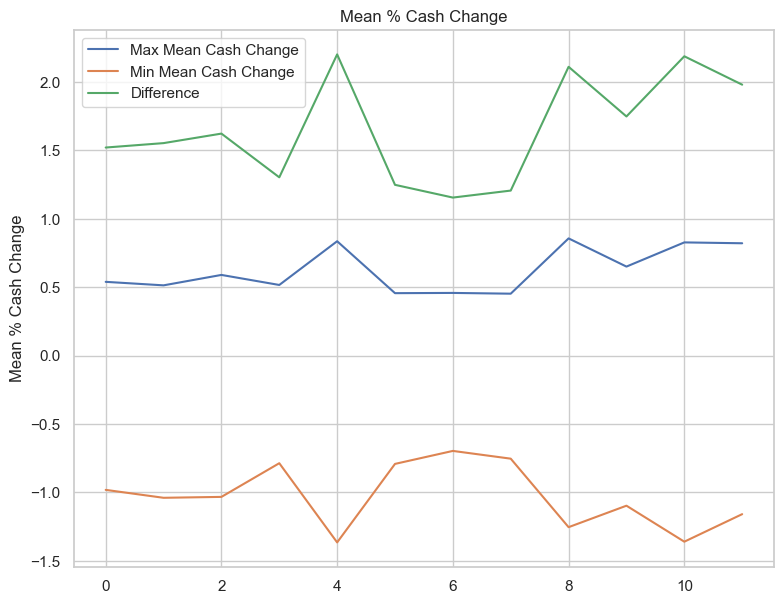

In [26]:
graph_locations =(location + r"\charts")
plt.style.use('default')
sns.set(style="whitegrid")

fig=plt.figure(figsize=(8,6))
sns.lineplot(x=cash_min_max_df.index,y=cash_min_max_df['Max Mean Cash Change'],label='Max Mean Cash Change')
sns.lineplot(x=cash_min_max_df.index,y=cash_min_max_df['Min Mean Cash Change'],label='Min Mean Cash Change')
sns.lineplot(x=cash_min_max_df.index,y=cash_min_max_df['Difference'],label='Difference')
plt.tight_layout()
title='Mean % Cash Change'
plt.title(title)
plt.ylabel('Mean % Cash Change')
plt.show()
fig.savefig(graph_locations+'\\'+title,bbox_inches='tight')

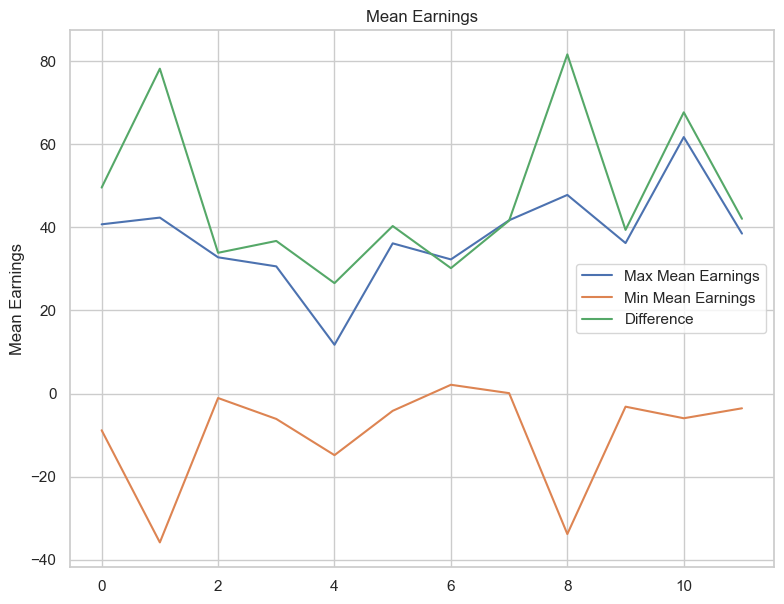

In [27]:
graph_locations =(location + r"\charts")
plt.style.use('default')
sns.set(style="whitegrid")

fig=plt.figure(figsize=(8,6))
sns.lineplot(x=earnings_min_max_df.index,y=earnings_min_max_df['Max Mean Earnings'],label='Max Mean Earnings')
sns.lineplot(x=earnings_min_max_df.index,y=earnings_min_max_df['Min Mean Earnings'],label='Min Mean Earnings')
sns.lineplot(x=earnings_min_max_df.index,y=earnings_min_max_df['Difference'],label='Difference')
plt.tight_layout()
title='Mean Earnings'
plt.title(title)
plt.ylabel('Mean Earnings')
plt.show()
fig.savefig(graph_locations+'\\'+title,bbox_inches='tight')

In [28]:
keep_cols =['pct_change_cash','Total Assets per share','Cash, Cash Equivalents & Short Term Investments per share','Retained Earnings per share']
bar_graph_df=group_basic['Q1_2018'][keep_cols]
bar_graph_df=bar_graph_df.rename(columns={'pct_change_cash':'% Change Cash'})

bar_graph_df=bar_graph_df.join(other=pd.DataFrame(value_count_dic['Q1_2018']).rename(columns={'Q1_2018':'Count'}))

In [29]:
name_list = ['Moderate','Low Assets 1','High Earnings and Assets','Cash Loss with Low Cash','Cash Increase, Low Cash','Low Assets 2','Moderate','Low Cash % Change',
              'High Cash, Good Earnings','Low Earnings, High Assets','Moderate','High Cash, Low Earnings','Moderate']
clst_list = bar_graph_df.index

In [30]:
index_remap = dict(zip(clst_list,name_list))

In [31]:
bar_graph_df=bar_graph_df.rename(index=index_remap)

In [32]:
bar_graph_df=bar_graph_df.drop(bar_graph_df.index[bar_graph_df.index=='Moderate'])

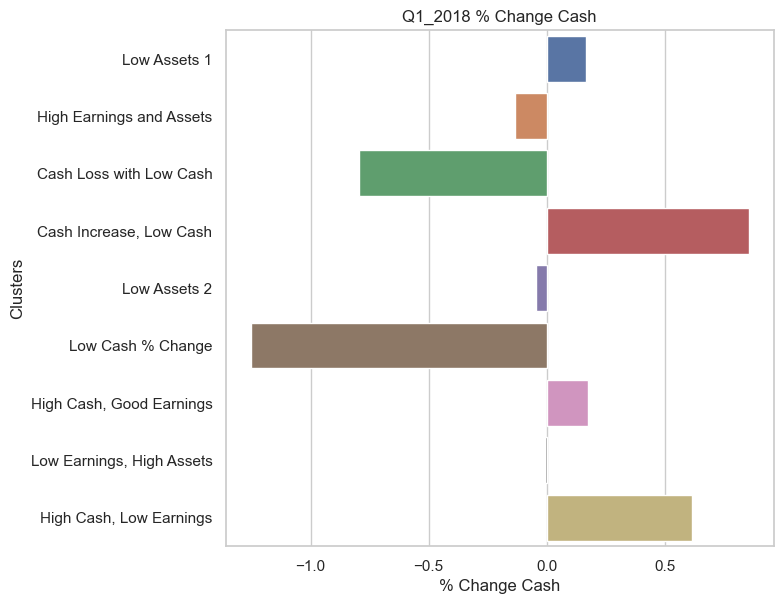

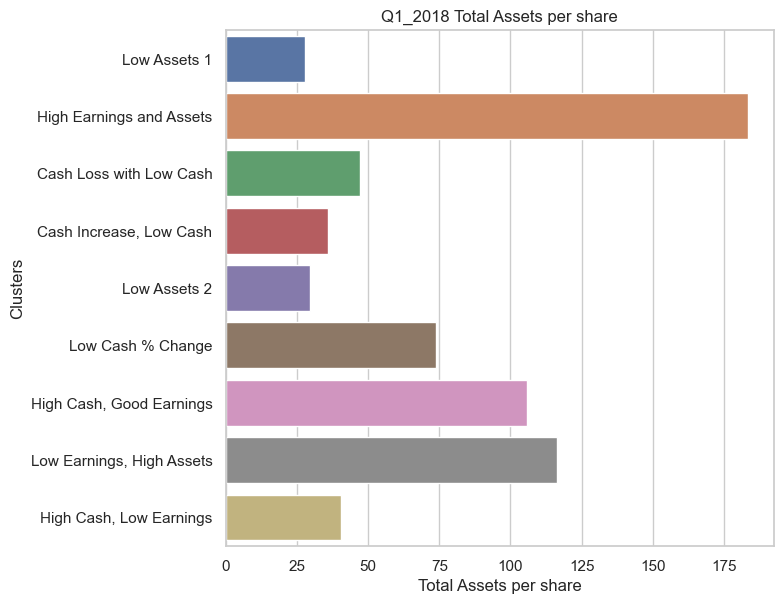

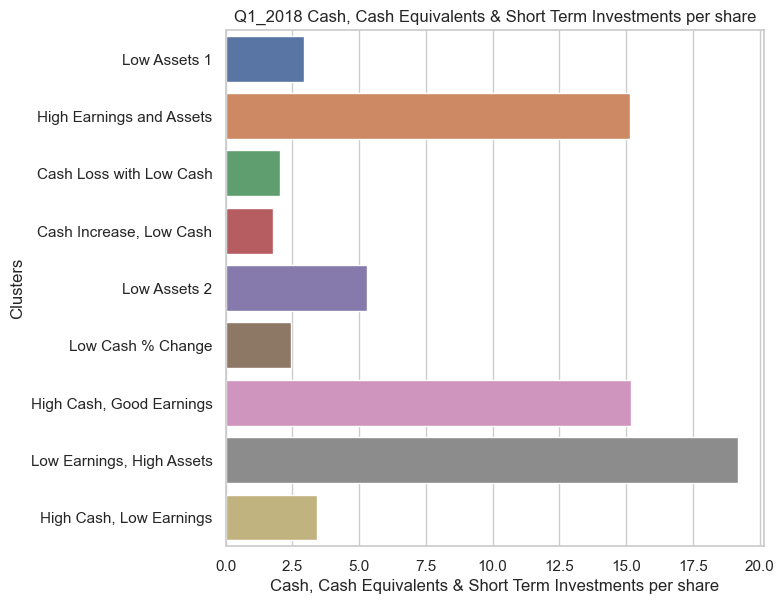

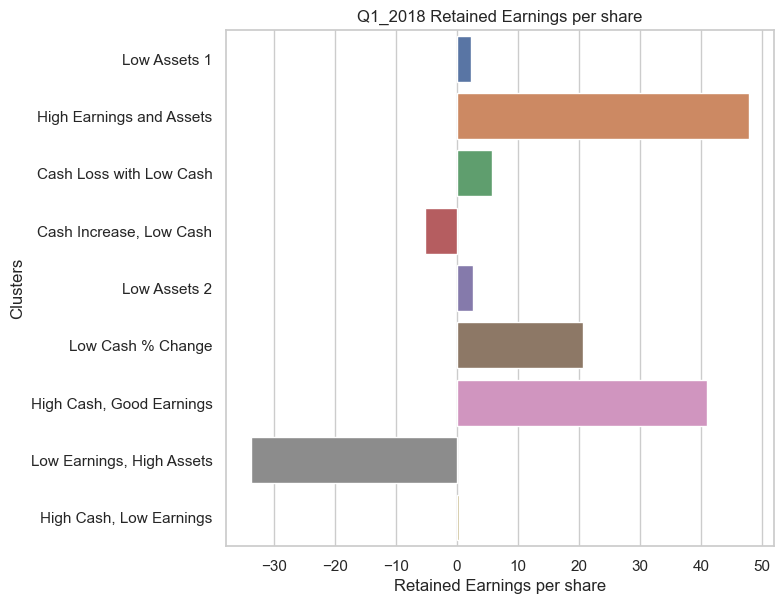

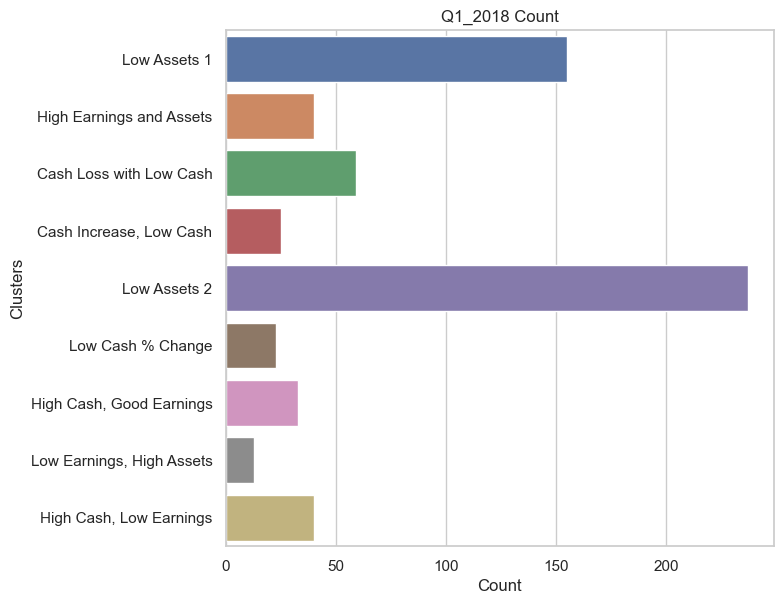

In [33]:
graph_locations =(location + r"\charts")
plt.style.use('default')
sns.set(style="whitegrid")
for col in bar_graph_df.columns:
    fig=plt.figure(figsize=(8,6))
    sns.barplot(y=bar_graph_df.index,x=bar_graph_df[col])
    plt.tight_layout()
    title='Q1_2018 '+col
    plt.title(title)
    plt.ylabel('Clusters')
    plt.show()
    fig.savefig(graph_locations+'\\barcharts\\'+title,bbox_inches='tight')

In [34]:
index_remap

{0.0: 'Moderate',
 2.0: 'Low Assets 1',
 4.0: 'High Earnings and Assets',
 5.0: 'Cash Loss with Low Cash',
 6.0: 'Cash Increase, Low Cash',
 7.0: 'Low Assets 2',
 8.0: 'Moderate',
 9.0: 'Low Cash % Change',
 12.0: 'High Cash, Good Earnings',
 13.0: 'Low Earnings, High Assets',
 14.0: 'Moderate',
 16.0: 'High Cash, Low Earnings',
 19.0: 'Moderate'}

Main Chart of Clusters in Q1_2018.  The biggest take aways are the clusters with varying levels of assets, earnings, cash and cash % change.

In [35]:
group_basic['Q1_2018'].rename(index=index_remap).drop(index='Moderate').style.background_gradient(axis=0)

High Cash, Low Earnings Stocks:

In [36]:
tick_list = quarter_df_dic['Q1_2018'].index[quarter_df_dic['Q1_2018']['Q1_2018']==16]
company_df['Company Name'][company_df['Ticker'].isin(tick_list)].values

array(['Apptio Inc', 'AMERICAN BIO MEDICA CORP', 'Cool Holdings, Inc.',
       'At Home Group Inc.', 'CONTINENTAL RESOURCES, INC',
       'WPX Energy Inc', 'U.S. Auto Parts Network, Inc.', "AARON'S INC",
       'Computer Programs & Systems Inc', 'Zimmer Biomet Holdings',
       'NEW RELIC, INC.', 'PERMA FIX ENVIRONMENTAL SERVICES INC',
       'MCBC Holdings, Inc.', 'Vista Outdoor Inc.',
       'AIR INDUSTRIES GROUP', 'SUPERNUS PHARMACEUTICALS INC',
       'AMEREN CORP', 'RingCentral Inc', 'Syros Pharmaceuticals, Inc.',
       'WESTAR ENERGY INC /KS', 'LHC Group, Inc',
       'NEW JERSEY RESOURCES CORP', 'ASPEN GROUP, INC.',
       'CONSTELLATION BRANDS, INC.', 'PURE BIOSCIENCE, INC.',
       'Carlisle Companies Inc', 'Verisign Inc.', 'ONE Gas, Inc.',
       'TANDEM DIABETES CARE INC', 'Atmos Energy Corp',
       'T-Mobile US, Inc.', 'Zendesk, Inc.', 'LOWES COMPANIES INC',
       'SUN HYDRAULICS CORP', 'ALAMO GROUP INC',
       'SBA COMMUNICATIONS CORP', 'Cabot Oil & Gas',
       'Exten

low assets 1 stocks:

In [37]:
tick_list = quarter_df_dic['Q1_2018'].index[quarter_df_dic['Q1_2018']['Q1_2018']==2.0]
company_df['Company Name'][company_df['Ticker'].isin(tick_list)].values

array(['ECOLOGY & ENVIRONMENT INC', 'KLX Inc.', 'Cotiviti Holdings, Inc.',
       'Destination Maternity Corp', 'ACETO CORP', 'MICROSEMI CORP',
       'Cavium Inc', 'FIRST DATA CORP', 'Gannett Co., Inc.',
       'Ascent Capital Group, Inc.', 'ESTERLINE TECHNOLOGIES CORP',
       'SYMANTEC CORP', 'CUMULUS MEDIA INC', 'LEE ENTERPRISES, INC',
       'PCM, INC.', 'BRIGGS & STRATTON CORP', 'QUALITY SYSTEMS, INC',
       'PETMED EXPRESS INC', 'RANGE RESOURCES CORP', 'NISOURCE INC/DE',
       'AK STEEL HOLDING CORP', 'SeaSpine Holdings Corp',
       'Acadia Pharmaceuticals Inc', 'MARINE PRODUCTS CORP',
       'Novocure Ltd', 'Digimarc CORP', 'Criteo S.A.', 'STERICYCLE INC',
       'EXTREME NETWORKS INC', 'Texas Roadhouse, Inc.', 'OMNICELL, Inc',
       'BJs RESTAURANTS INC', 'GULFPORT ENERGY CORP', 'Clarus Corp',
       'RUBY TUESDAY INC', 'Mylan N.V.', 'IMPINJ INC', 'Five9, Inc.',
       'SYNCHRONOSS TECHNOLOGIES INC', 'FORESCOUT TECHNOLOGIES, INC',
       'AES CORP', 'GrubHub Inc.', 'KRONOS

low earnings, high assets stocks:

In [38]:
tick_list = quarter_df_dic['Q1_2018'].index[quarter_df_dic['Q1_2018']['Q1_2018']==13.0]
company_df['Company Name'][company_df['Ticker'].isin(tick_list)].values

array(['iHeartMedia, Inc.', 'PIER 1 IMPORTS INC/DE',
       'INTERCEPT PHARMACEUTICALS INC', 'NEWLINK GENETICS CORP',
       'NOVAVAX INC', 'DOCUSIGN INC', 'EXCO RESOURCES INC',
       'Denali Holding Inc.', 'SIGNET JEWELERS LTD', 'CIENA CORP',
       'QUALCOMM INC/DE', 'Tesla',
       'Valeant Pharmaceuticals International, Inc.'], dtype=object)

high cash, good earnings Stocks:

In [39]:
tick_list = quarter_df_dic['Q1_2018'].index[quarter_df_dic['Q1_2018']['Q1_2018']==12.0]
company_df['Company Name'][company_df['Ticker'].isin(tick_list)].values

array(['WestRock Co', 'WELLCARE HEALTH PLANS, INC.', 'FMC Corporation',
       'Laboratory Corp. of America Holding', 'MOHAWK INDUSTRIES INC',
       'Cimarex Energy', 'JONES LANG LASALLE INC',
       'ADVANCE AUTO PARTS INC', 'STAMPS.COM INC', 'VMWARE, INC.',
       'ACUITY BRANDS INC', 'MICRON TECHNOLOGY INC',
       'COSTCO WHOLESALE CORP /NEW', 'BIOGEN INC.', 'SNAP-ON Inc',
       'CHIPOTLE MEXICAN GRILL INC', 'UNITED THERAPEUTICS Corp',
       'HERSHEY CO', 'BOEING CO', 'AMGEN INC', 'APPLE INC',
       'GENERAL DYNAMICS CORP', 'MOODYS CORP /DE/', 'LyondellBasell',
       'The Walt Disney Company', 'AMERISOURCEBERGEN CORP',
       'TransDigm Group', 'Regeneron', 'UNITEDHEALTH GROUP INC',
       'HCA Holdings', 'CHEVRON CORP', 'CHEMED CORP',
       'HollyFrontier Corp'], dtype=object)

Low Asset 2 Stocks:

In [40]:
tick_list = quarter_df_dic['Q1_2018'].index[quarter_df_dic['Q1_2018']['Q1_2018']==7.0]
company_df['Company Name'][company_df['Ticker'].isin(tick_list)].values

array(['FREDS INC', 'CAPSTONE TURBINE Corp', 'SOHU COM INC',
       'ROWAN COMPANIES PLC', 'CA, INC.',
       'Monotype Imaging Holdings Inc.', 'Medidata Solutions, Inc.',
       'Hortonworks, Inc.', 'MINDBODY, Inc.', 'Tableau Software Inc',
       'QUANTENNA COMMUNICATIONS INC', 'GENOMIC HEALTH INC',
       'GLOBAL BRASS & COPPER HOLDINGS, INC.', 'IMMUNE DESIGN CORP.',
       'OncoMed Pharmaceuticals Inc', 'Carbon Black, Inc.',
       'WESTELL TECHNOLOGIES INC', 'NEWS CORP', 'NUTRI SYSTEM INC /DE/',
       'Cinedigm Corp.', 'LANTRONIX INC', 'VINCE HOLDING CORP.',
       'SONO TEK CORP', 'LOGITECH INTERNATIONAL SA', 'HASBRO INC',
       'CubeSmart', 'ON SEMICONDUCTOR CORP', 'GIBRALTAR INDUSTRIES, INC.',
       'DRIL-QUIP INC', 'BRINKS CO', 'ROYAL CARIBBEAN CRUISES LTD',
       'Ryder System', '8X8 INC /DE/', 'Ribbon Communications Inc.',
       'MURPHY OIL CORP /DE', 'STEEL DYNAMICS INC', 'Wayfair Inc.',
       'COGNIZANT TECHNOLOGY SOLUTIONS CORP', 'TWILIO INC', 'Fluor Corp.',
       

The goal with this project was to raise visibility of less prominent stocks.  To truly evaluate the effectiveness of the clusters, a trading strategy would have to be built on those clusters.

In order to reliably attempt to generate a robust trading strategy off of this style of analysis, the source data needs improvement.  Missing stock-quarters and missing variables are problematic.  The graphs have shown very little overall variance.  There might be 30 or so variables, but most are highly correlated with each other by definition.  There is promise in the concept, but it requires far more data to reliably predict.  Hopefully with additional data, there will be enough variance to cluster all stock-quarters together rather than go by individual quarter which will help streamline the analysis.